# Buffer zone effects

## import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

# local python scripts
import os
import time

import numpy as np
import verde as vd
import xarray as xr
from invert4geom import utils as inv_utils, optimization
from polartoolkit import fetch, maps, regions, utils

import RIS_gravity_inversion.utils as RIS_utils
# from RIS_gravity_inversion import optimization


os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

# Optimal buffer zone width

The gravity inversion will compute the forward gravity of a layer of prisms with their tops defined by a topographic surface and bases defined by the minimum value of that surface. As you approach the edge of this layer of prisms, the apparent density contrast with the void space beyond the prism layer will results in a decay of the calculated gravity. For this reason, we introduce a buffer zone, with the forward gravity calculated only inside this buffer zone, while the prism layer extends beyond. This limits the majority of the gravity decay to beyond the region of interest. 

Too big of a buffer zone will add an unnecessary amount of computation (more prisms), while too small of a zone will introduce unacceptably large edge effects. 

By using a layer of prisms with flat tops and bottoms, we know the true value of the forward gravity should be true in the center of the region, and decrease toward the edges the observation point approach the edge of the layer of prisms. To calculate the `gravity decay`, we compare the maximum forward gravity (at the center) with the minumum forward gravity (along the edges) to give us a percent decay.

This decay is a function of both the observation height and the prism properties, such as their density and geometries. 

We use the function `optimal_buffer` in the `utils.py` script to find the buffer zone width which will limit the amount of gravity decay within a specified region of interest to a specified decay percentage (by default is 5% decay), for a specific set of prism and observation properties. 

Here, we show how this function works. 

# Example 1
Show the amount of gravity decay within the region of interest when using a buffer width of 10% of the widest survey dimension.

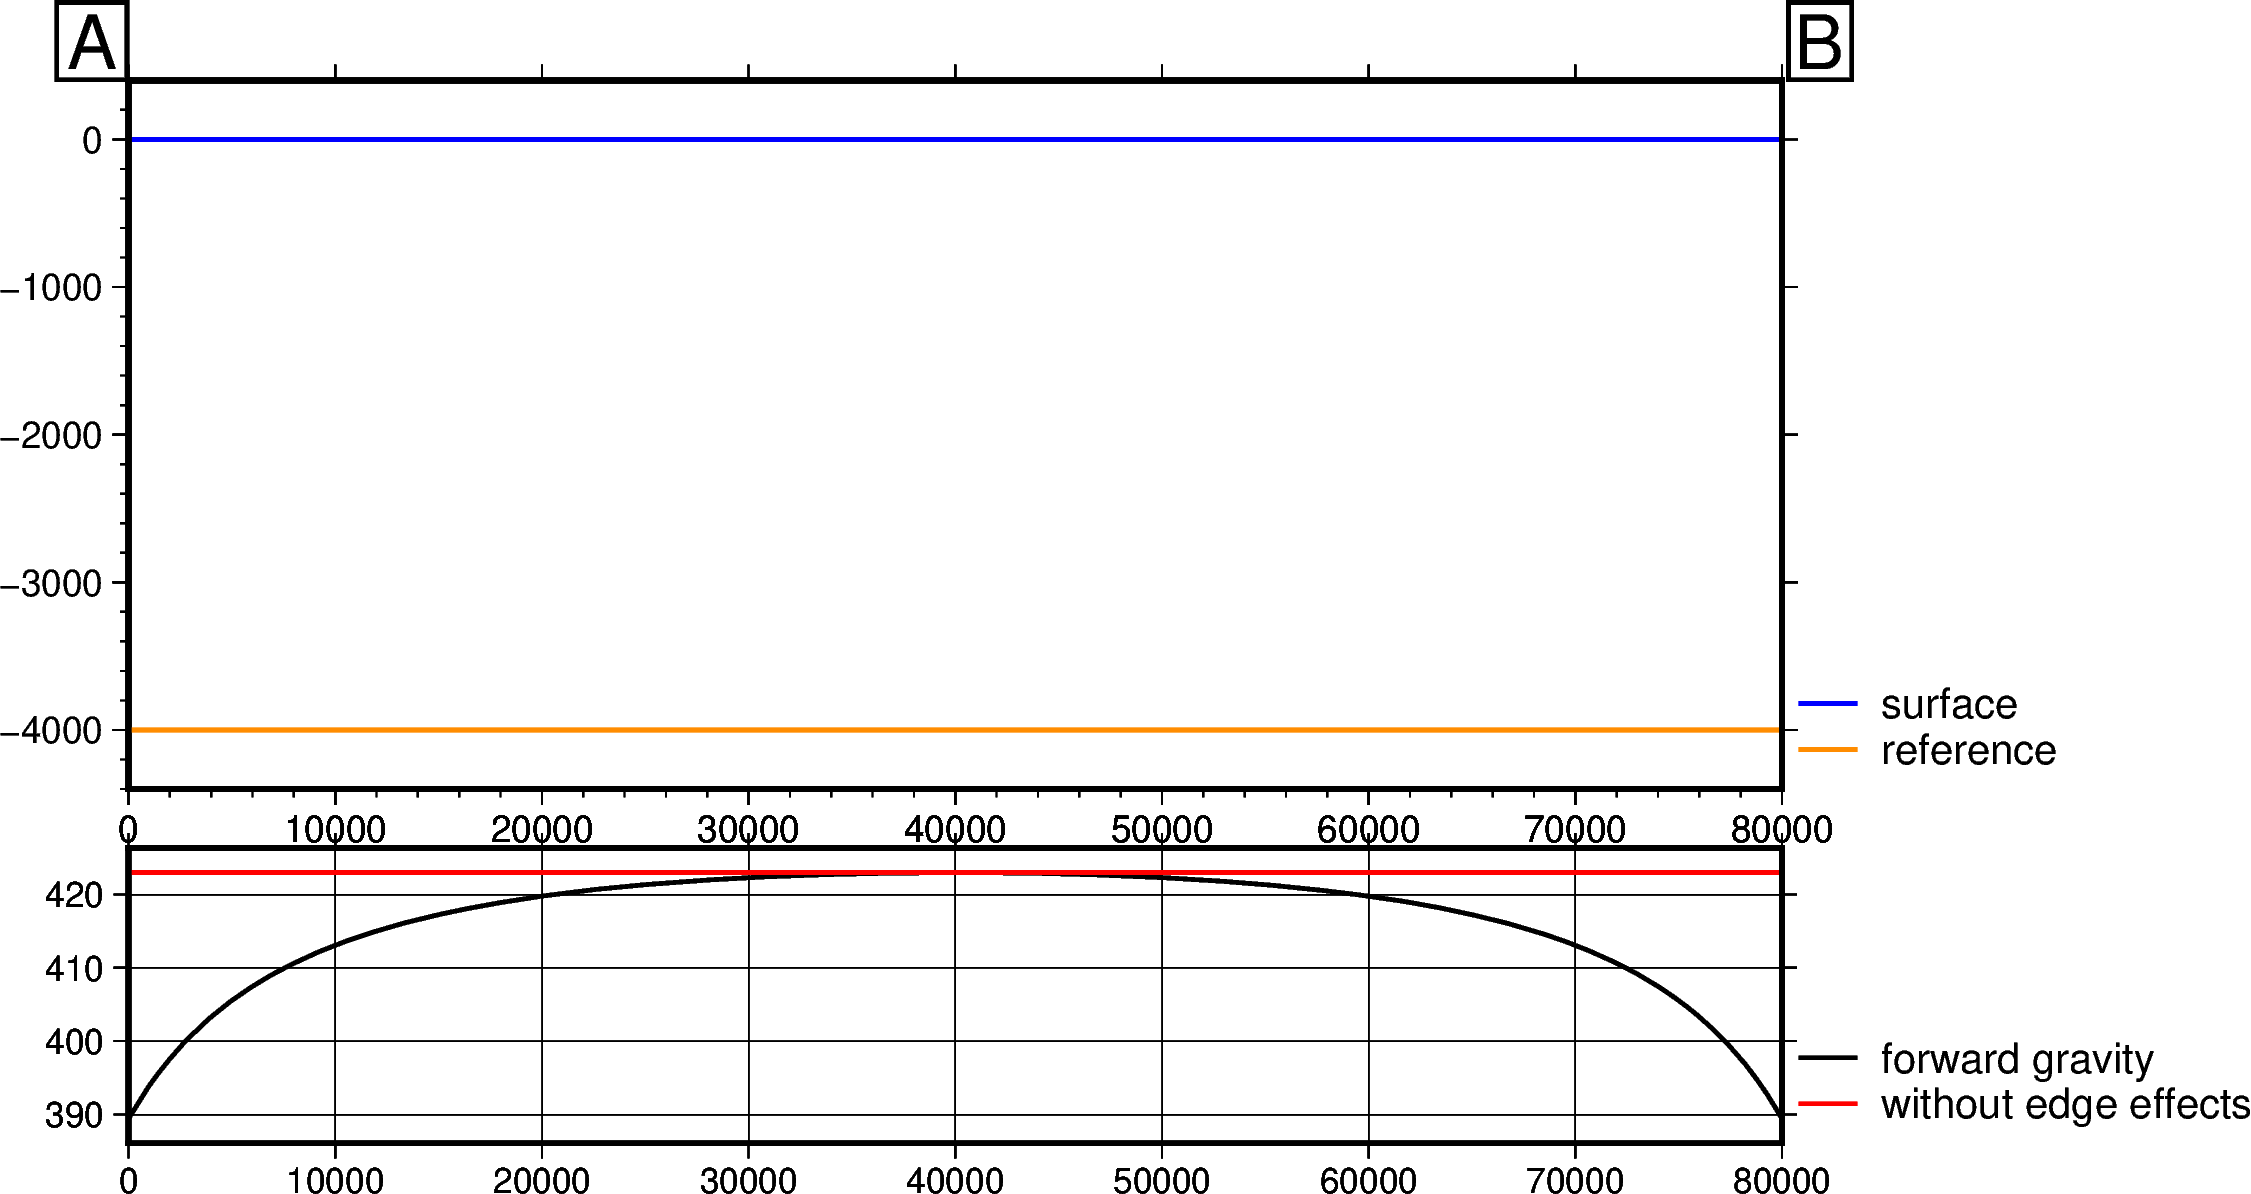

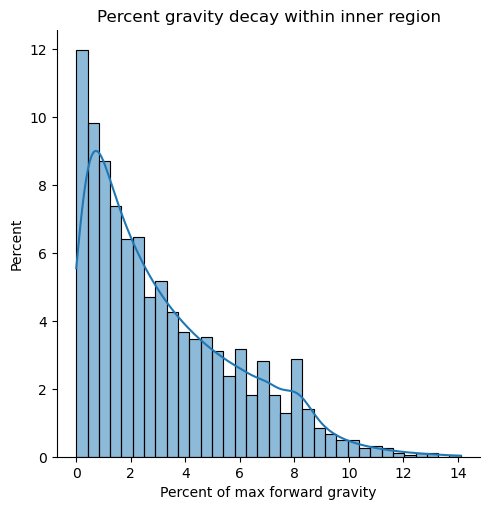

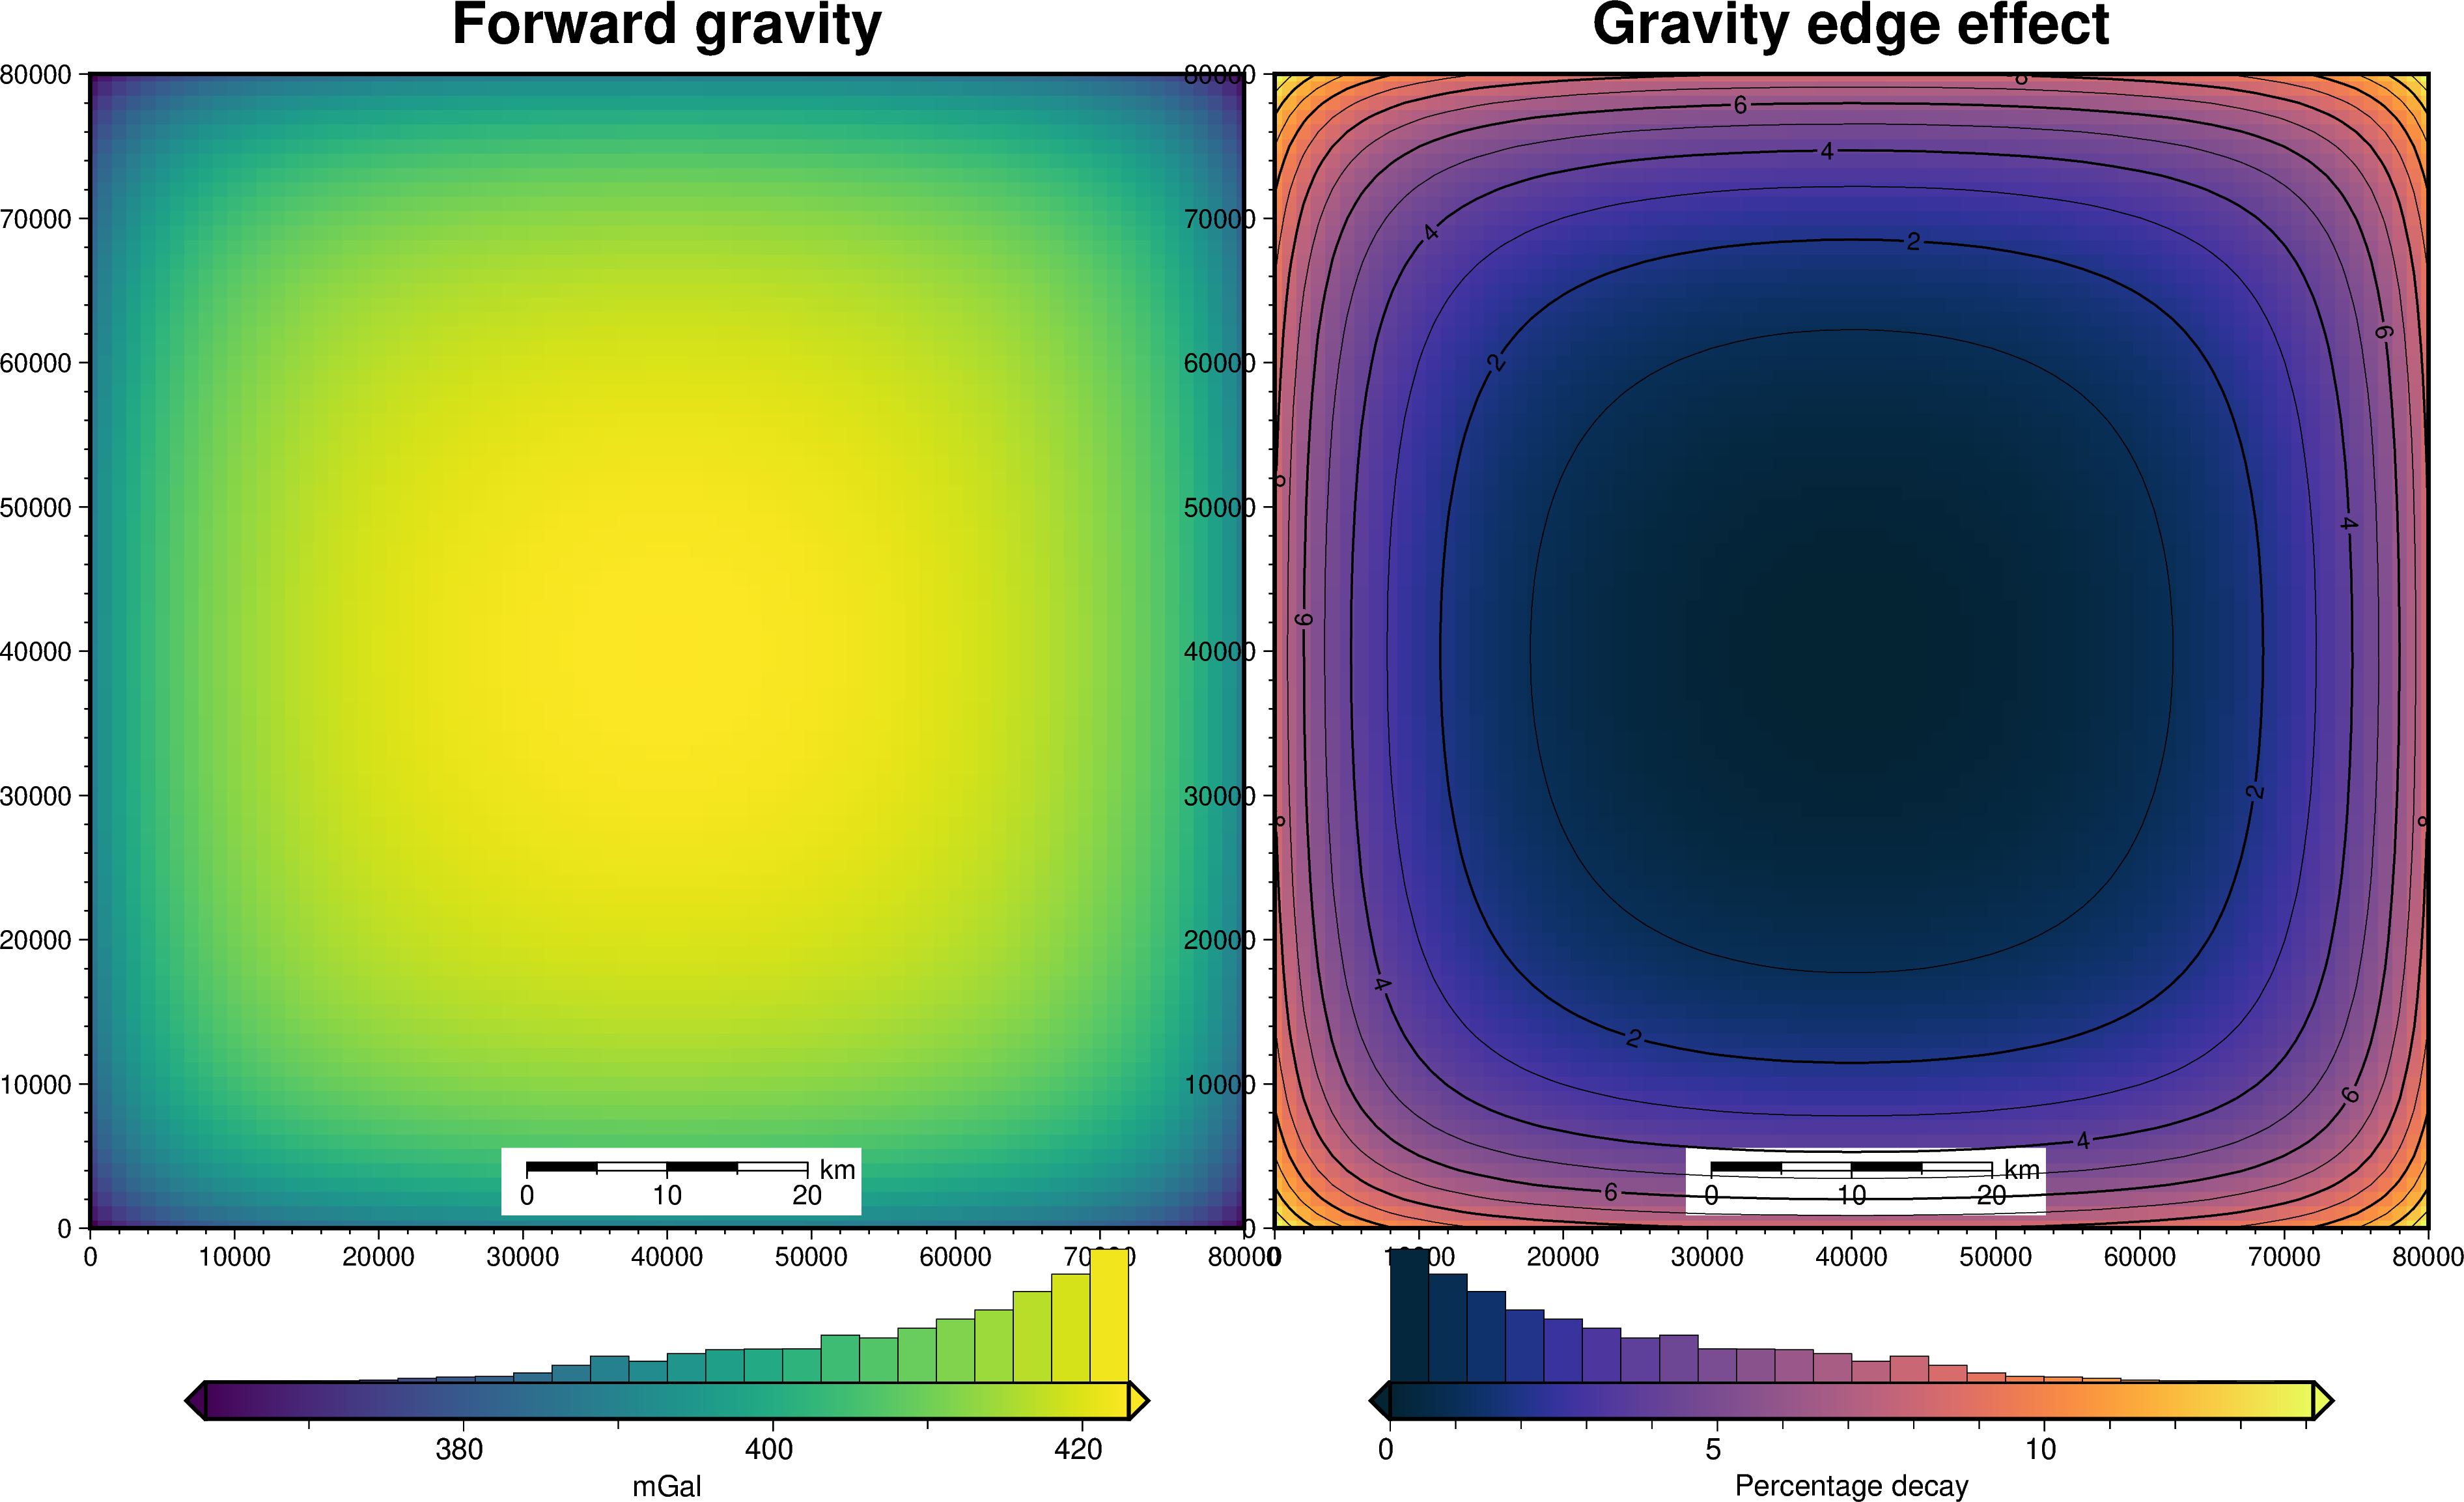

maximum decay: 14% 
buffer: 8000.0m / 8 cells


In [2]:
results = inv_utils.gravity_decay_buffer(
    buffer_perc=10,
    obs_height=1e3,
    top=0,
    zref=-4e3,
    spacing=1e3,
    inner_region=[0e3, 80e3, 0e3, 80e3],
    density=2670,
    plot=True,
)
print(
    f"maximum decay: {int(results[0])}% \n"
    f"buffer: {results[1]}m / {int(results[2])} cells"
)

## Results

This shows for this specific prism layer and survey geometry, the gravity decay within the region of interest is up to 14% when using a buffer zone of 8 km, or 10% of the regions width.

# Example 2

Find the buffer zone width which limits decay to only 3% for the specific prism layer and survey geometry.

First, run an optimization which calculates the percent decay with all buffer zone widths between 1-100% of the regions width.

In [3]:
study, study_df = optimization.optimal_buffer(
    target=3,
    buffer_perc_range=[1, 100],
    n_trials=100,
    obs_height=100,
    top=50,
    zref=-200,
    spacing=50,
    inner_region=[0, 1e3, 0e3, 600],
    density=400,
)

[I 2024-12-08 22:15:49,888] A new study created in memory with name: no-name-9cf117b2-8293-4027-a304-39e376cb23d8


{'buffer_perc': 64}


This shows that a buffer zone of 650m (63-67%) of the region's width gives a decay closest to 3%.

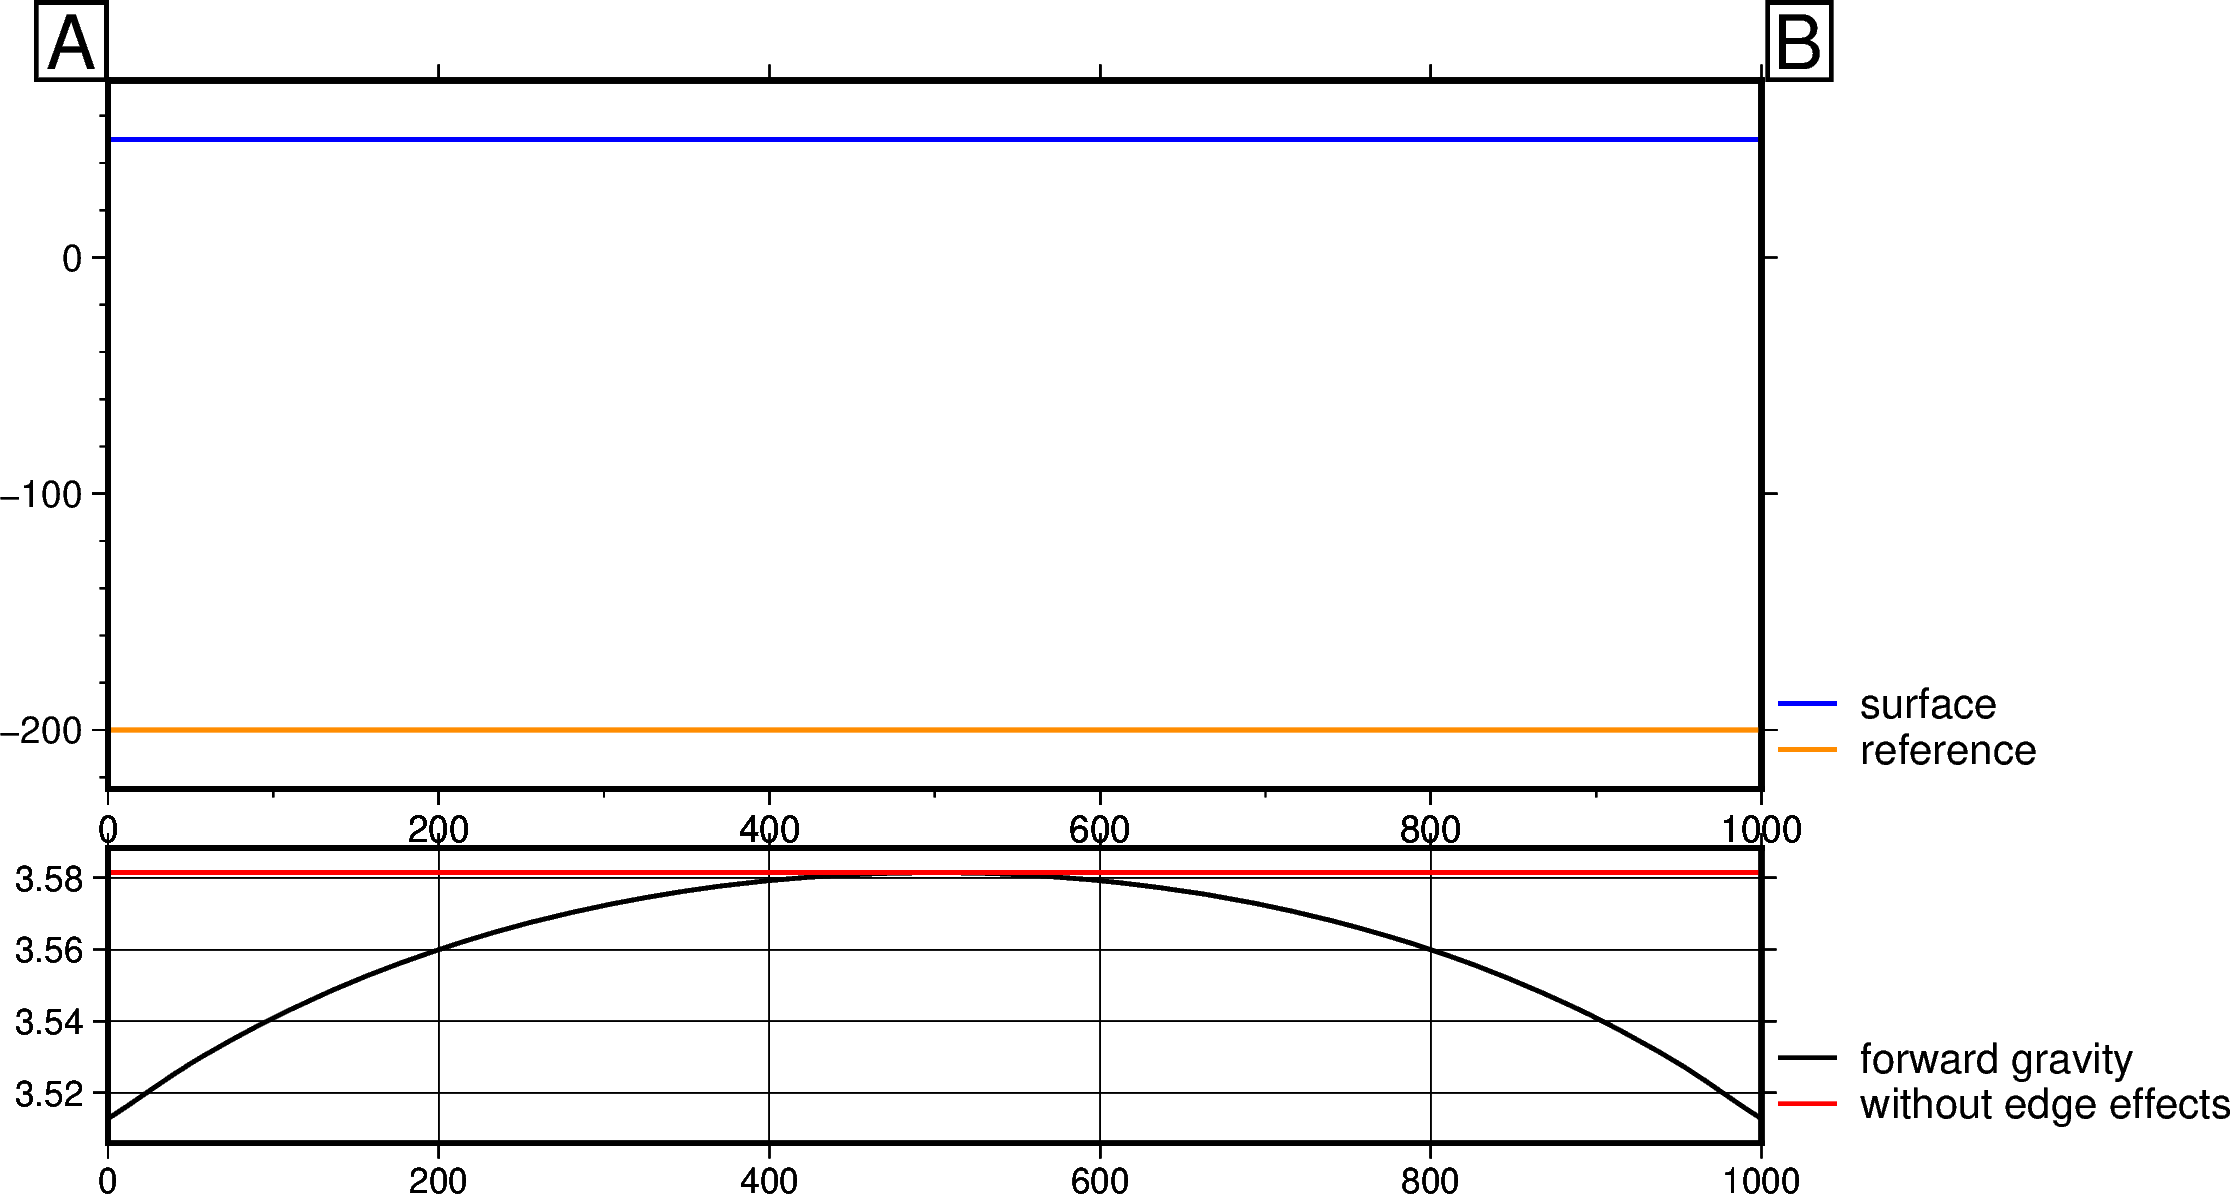

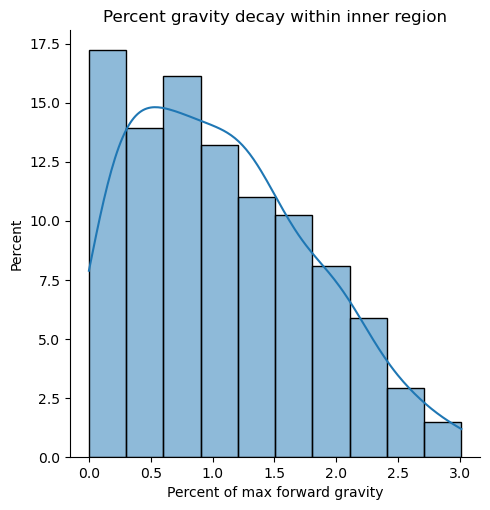

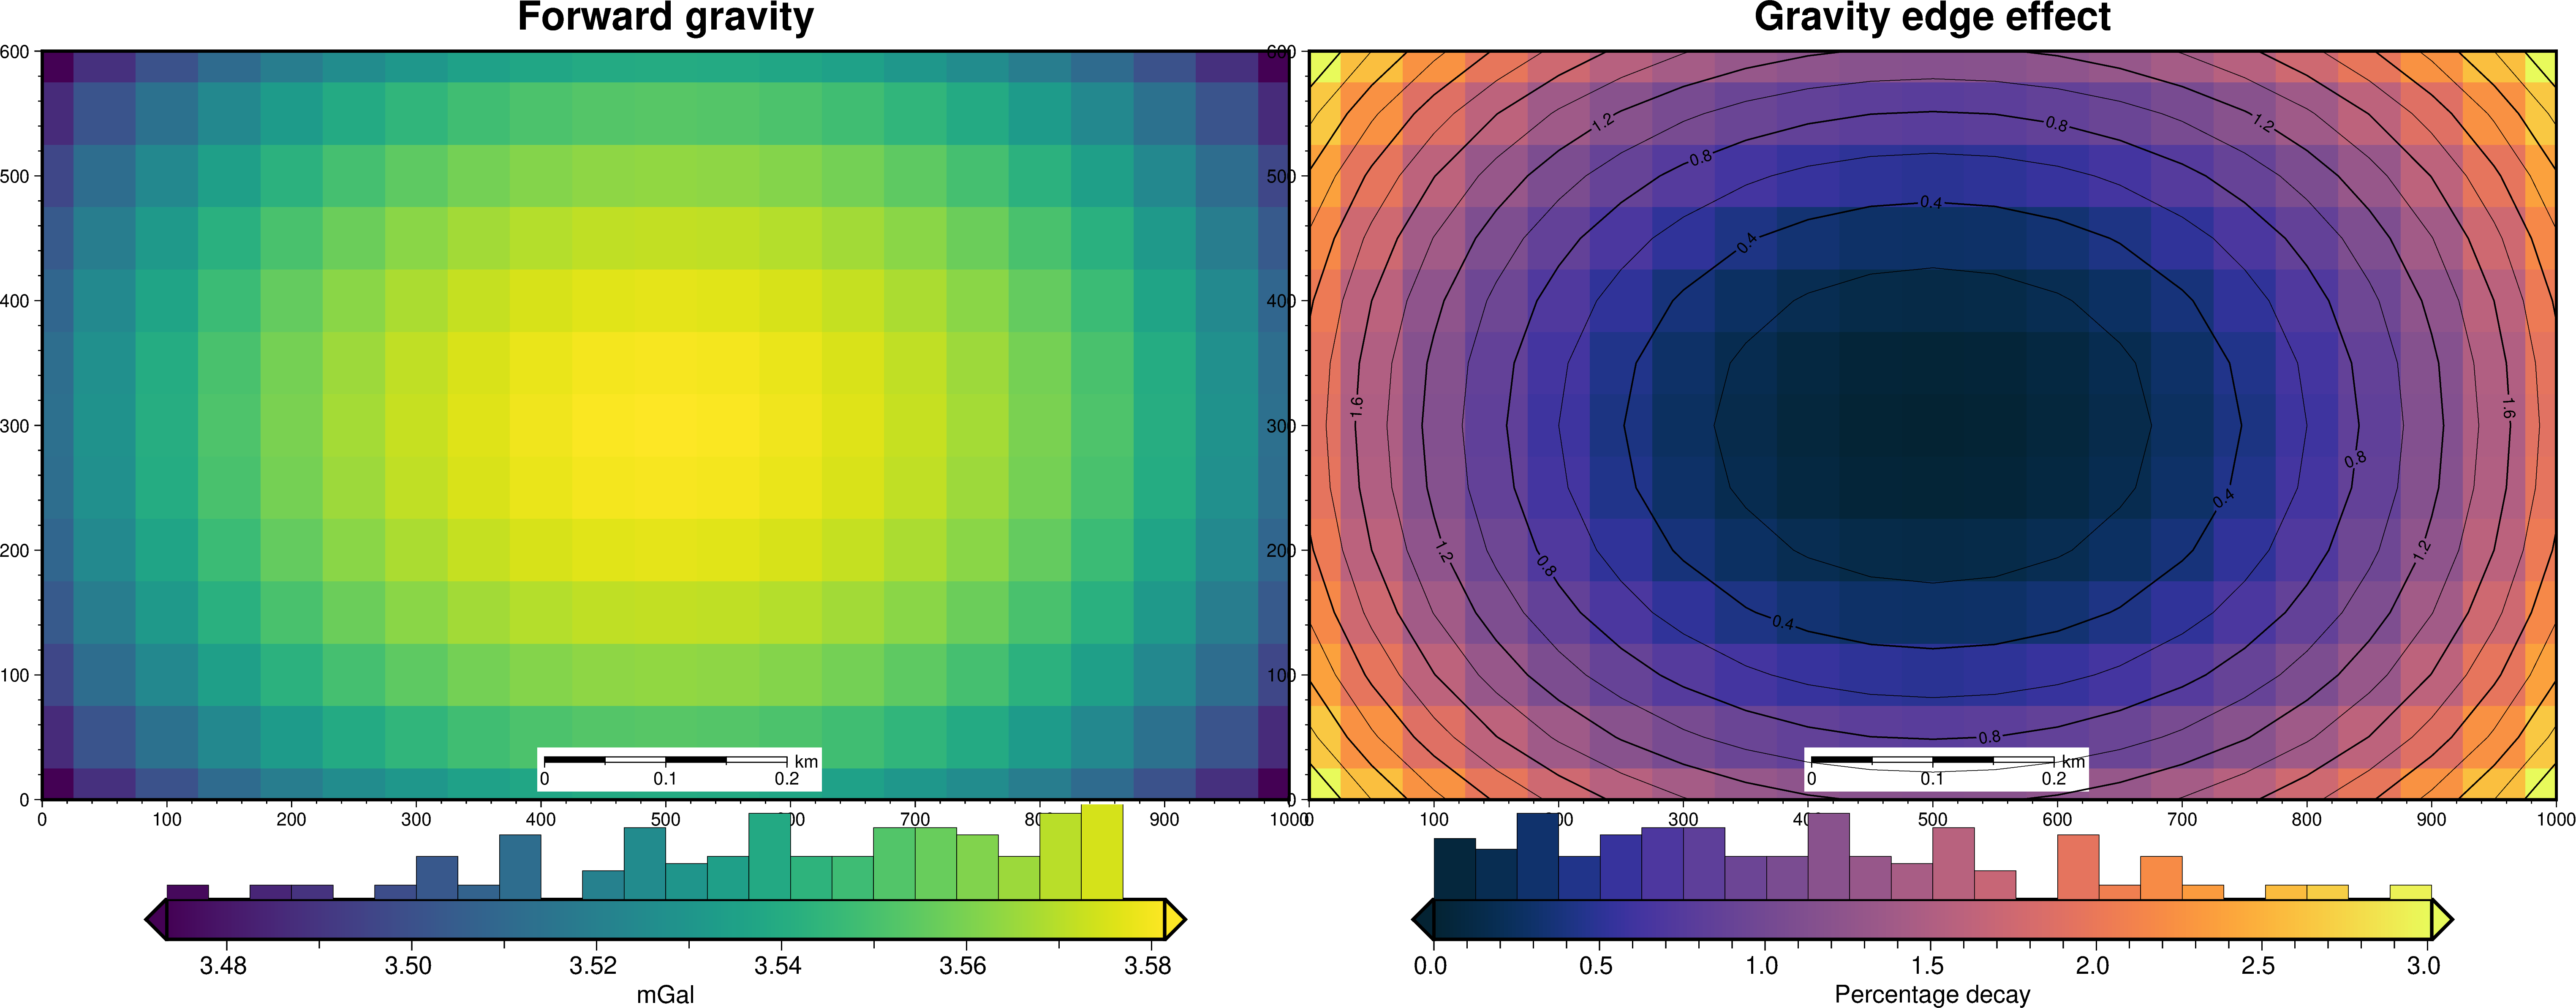

maximum decay: 3% 
buffer: 650m / 13 cells


In [4]:
# plot decay results
results = inv_utils.gravity_decay_buffer(
    buffer_perc=study.best_params["buffer_perc"],
    obs_height=100,
    top=50,
    zref=-200,
    spacing=50,
    inner_region=[0, 1e3, 0e3, 600],
    density=400,
    plot=True,
)
optimal_buffer = results[1]
print(
    f"maximum decay: {int(results[0])}% \n"
    f"buffer: {results[1]}m / {int(results[2])} cells"
)

# Example 3

Here we show the effects of a buffer zone when using prisms build around a reference, instead of prisms build from a surface to a constant base. With a reference which is within the range of the surface, prisms above the reference are assigned a postive density contrast, while prisms below have a negative density contrast.

The prisms above and below the reference produce opposite edge effects, create a net edge effect much lower than it would be with a standard setup. 

To test this, we can't use a flat surface, like above, but need an undulating surface. With the keyword argument `checkerboard = True`, we can show the buffer effect for a non-flat surface. This surface is a checkboard which can be altered with arguments `amplitude` and `wavelength`.

Below we show the decay for a standard prism model, with the tops defined by this checkerboard (same parameters as Example 1)

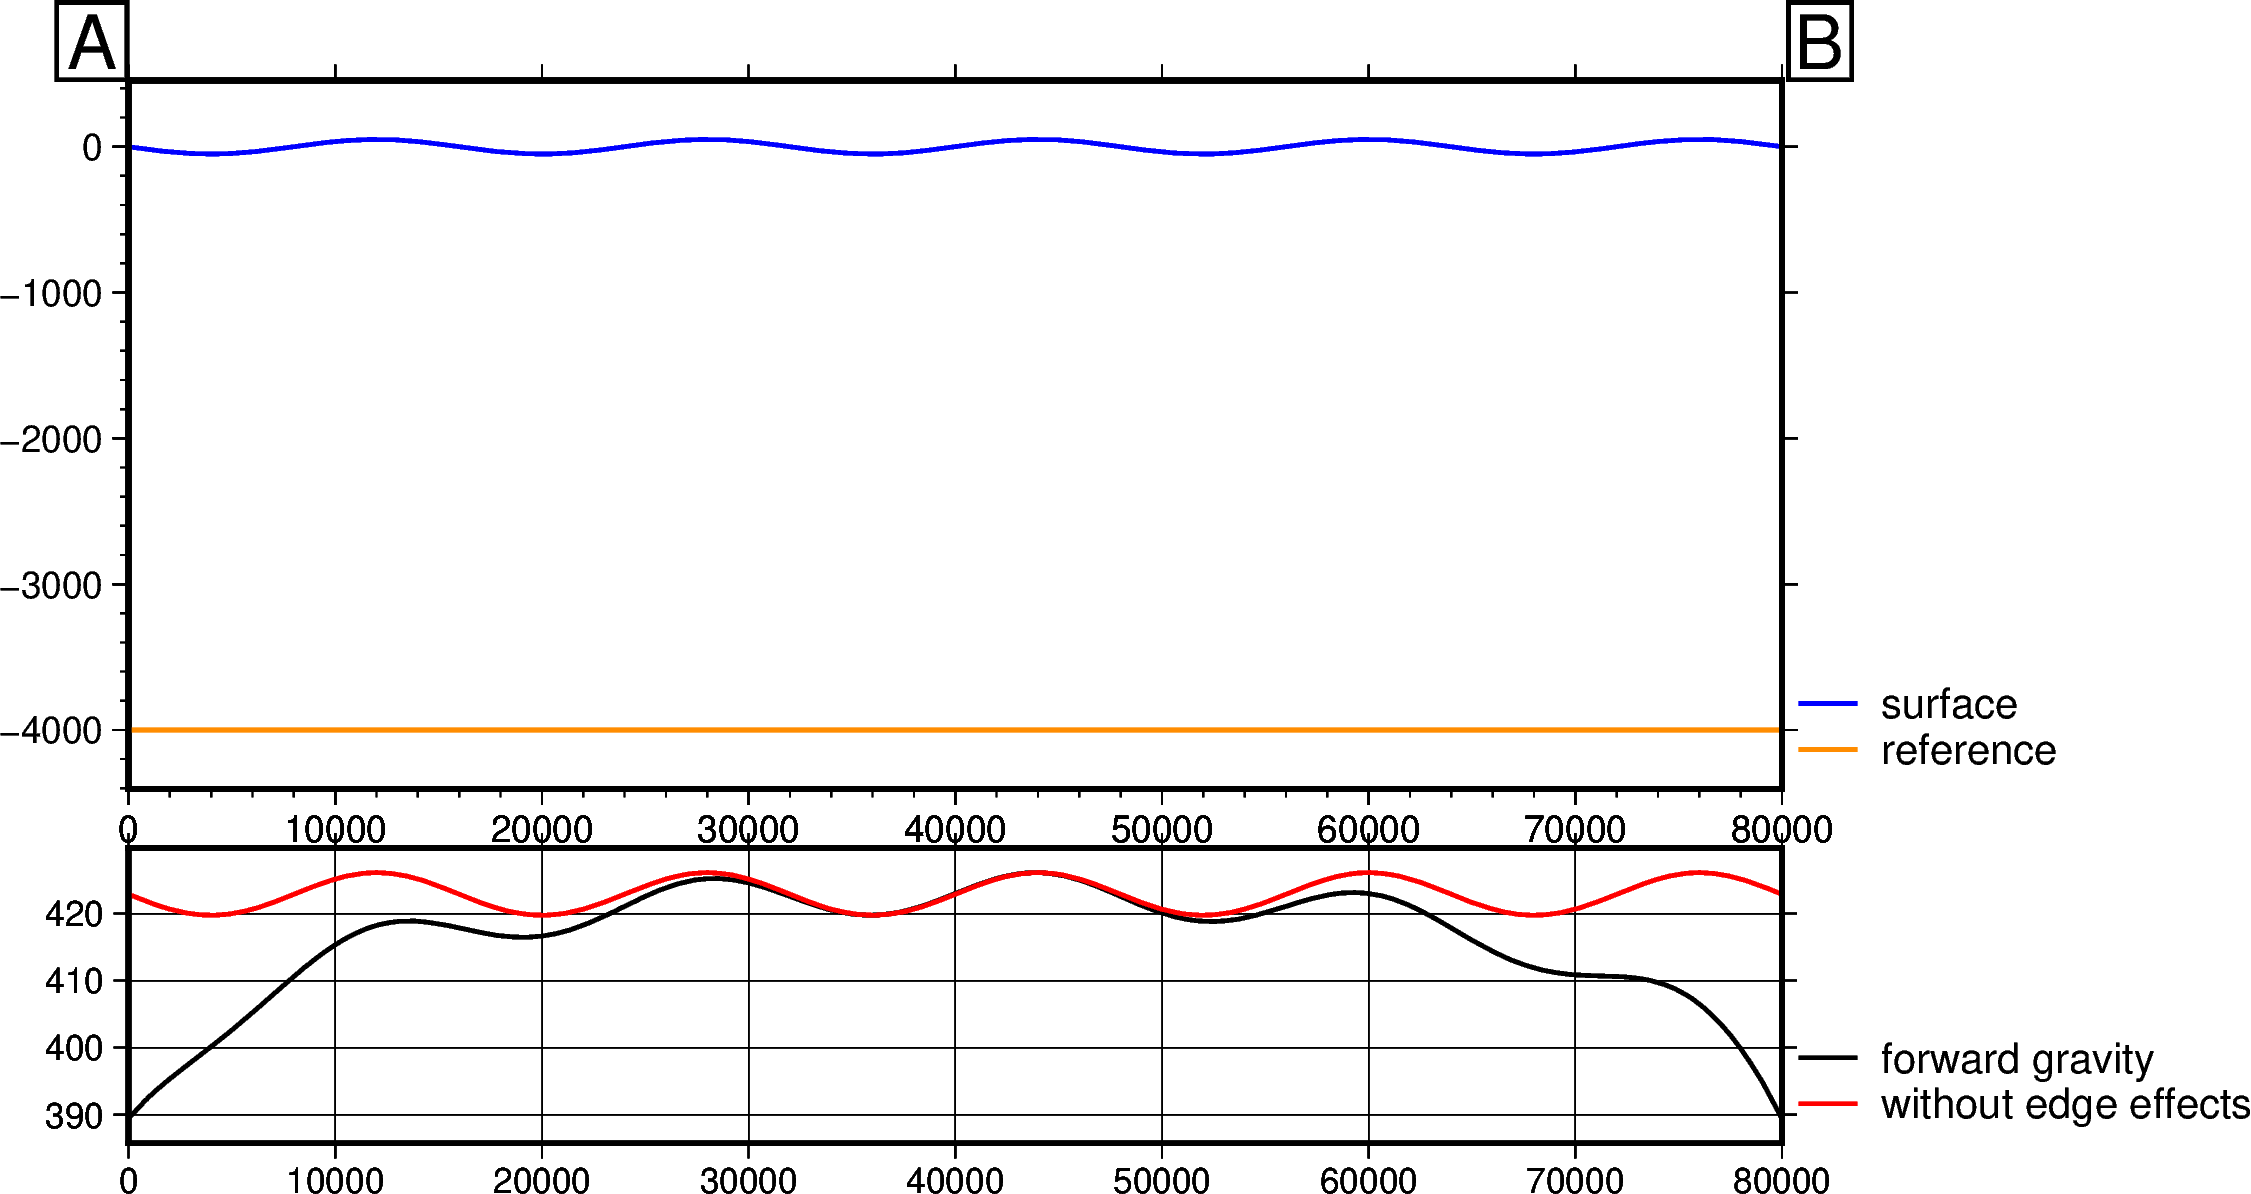

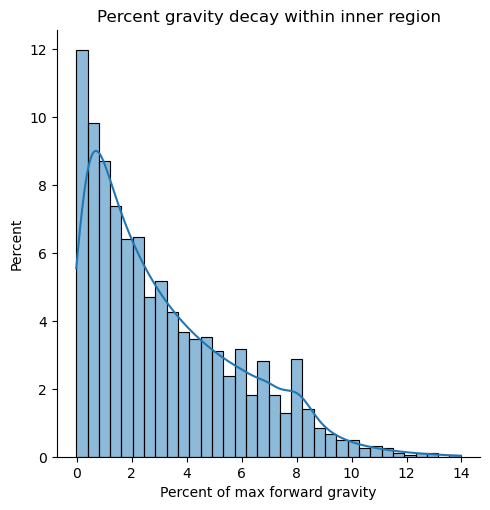

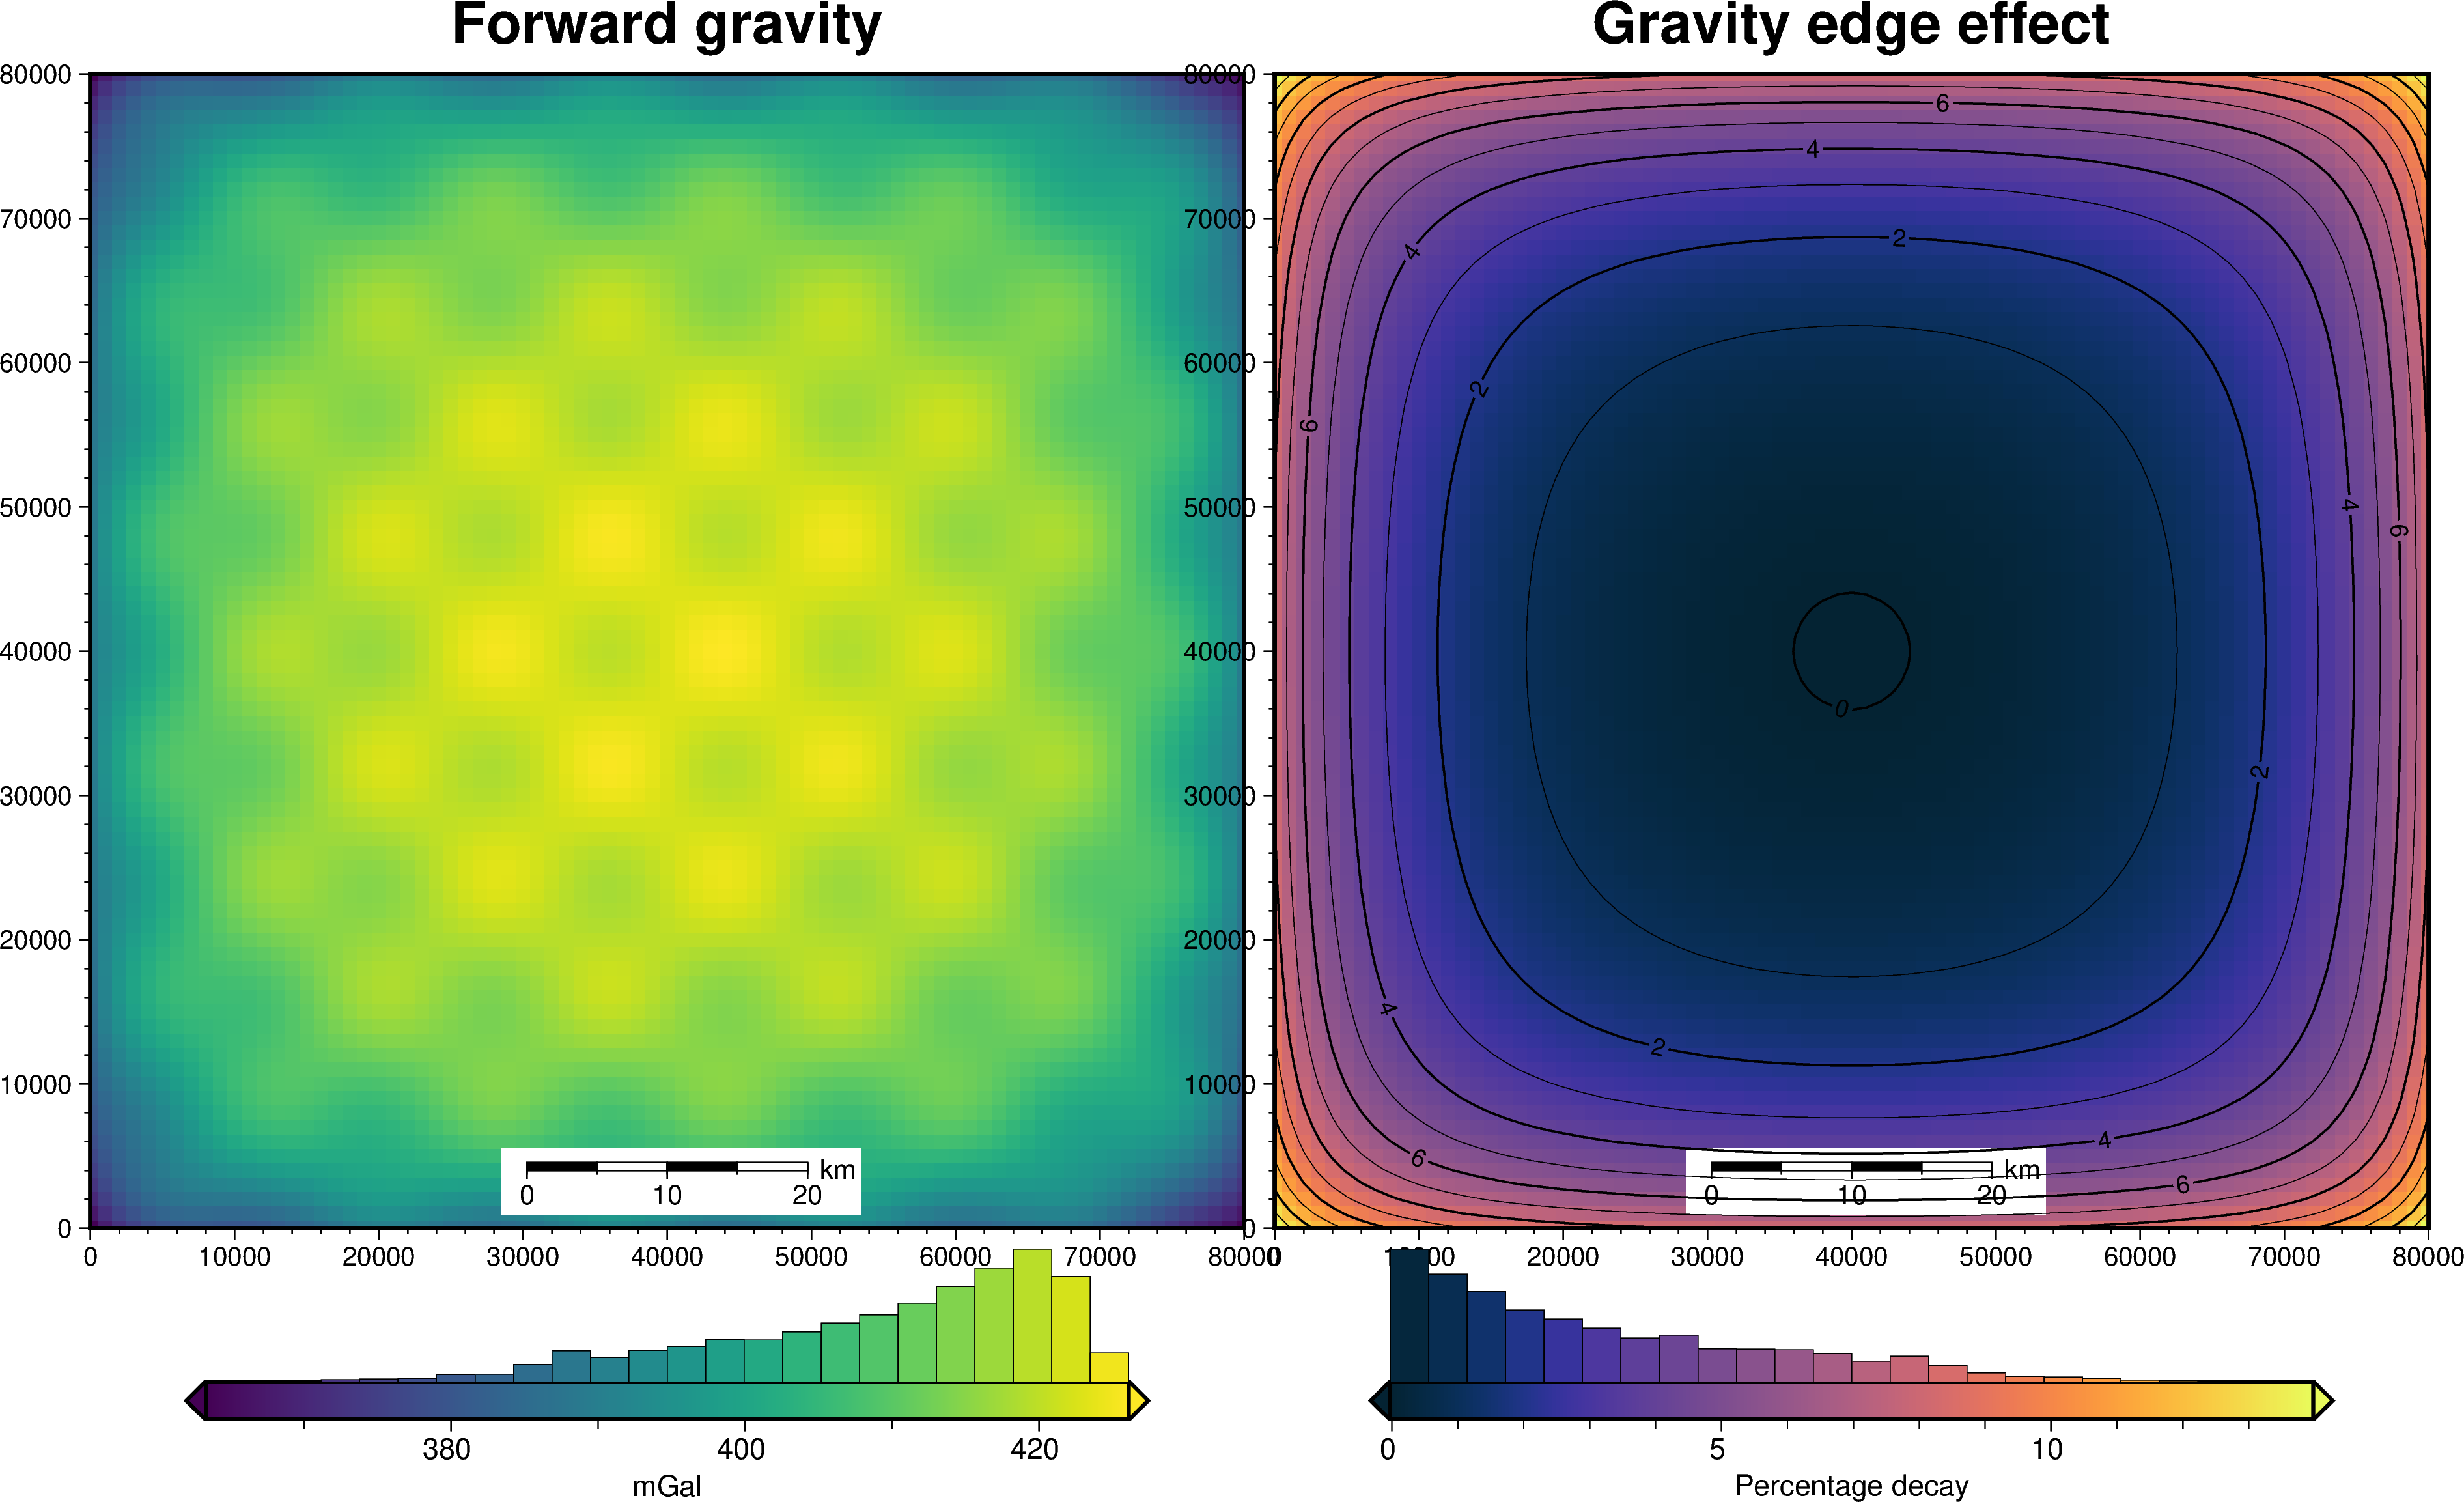

maximum decay: 13% 
buffer: 8000.0m / 8 cells


In [ ]:
results = inv_utils.gravity_decay_buffer(
    buffer_perc=10,
    obs_height=1e3,
    top=0,
    zref=-4e3,
    spacing=1e3,
    inner_region=[0e3, 80e3, 0e3, 80e3],
    density=2670,
    checkerboard=True,
    amplitude=50,
    wavelength=16e3,
    plot=True,
    plot_profile=True,
)
print(
    f"maximum decay: {int(results[0])}% \n"
    f"buffer: {results[1]}m / {int(results[2])} cells"
)

You can see this produces the same results as Example 1, ~13% decay.

Now we do the same, but with keyword argument `as_density_contrast = True`, the prisms are build around the mean value of the checkerboard, with prisms above having a positive density, and prisms below a negative density.

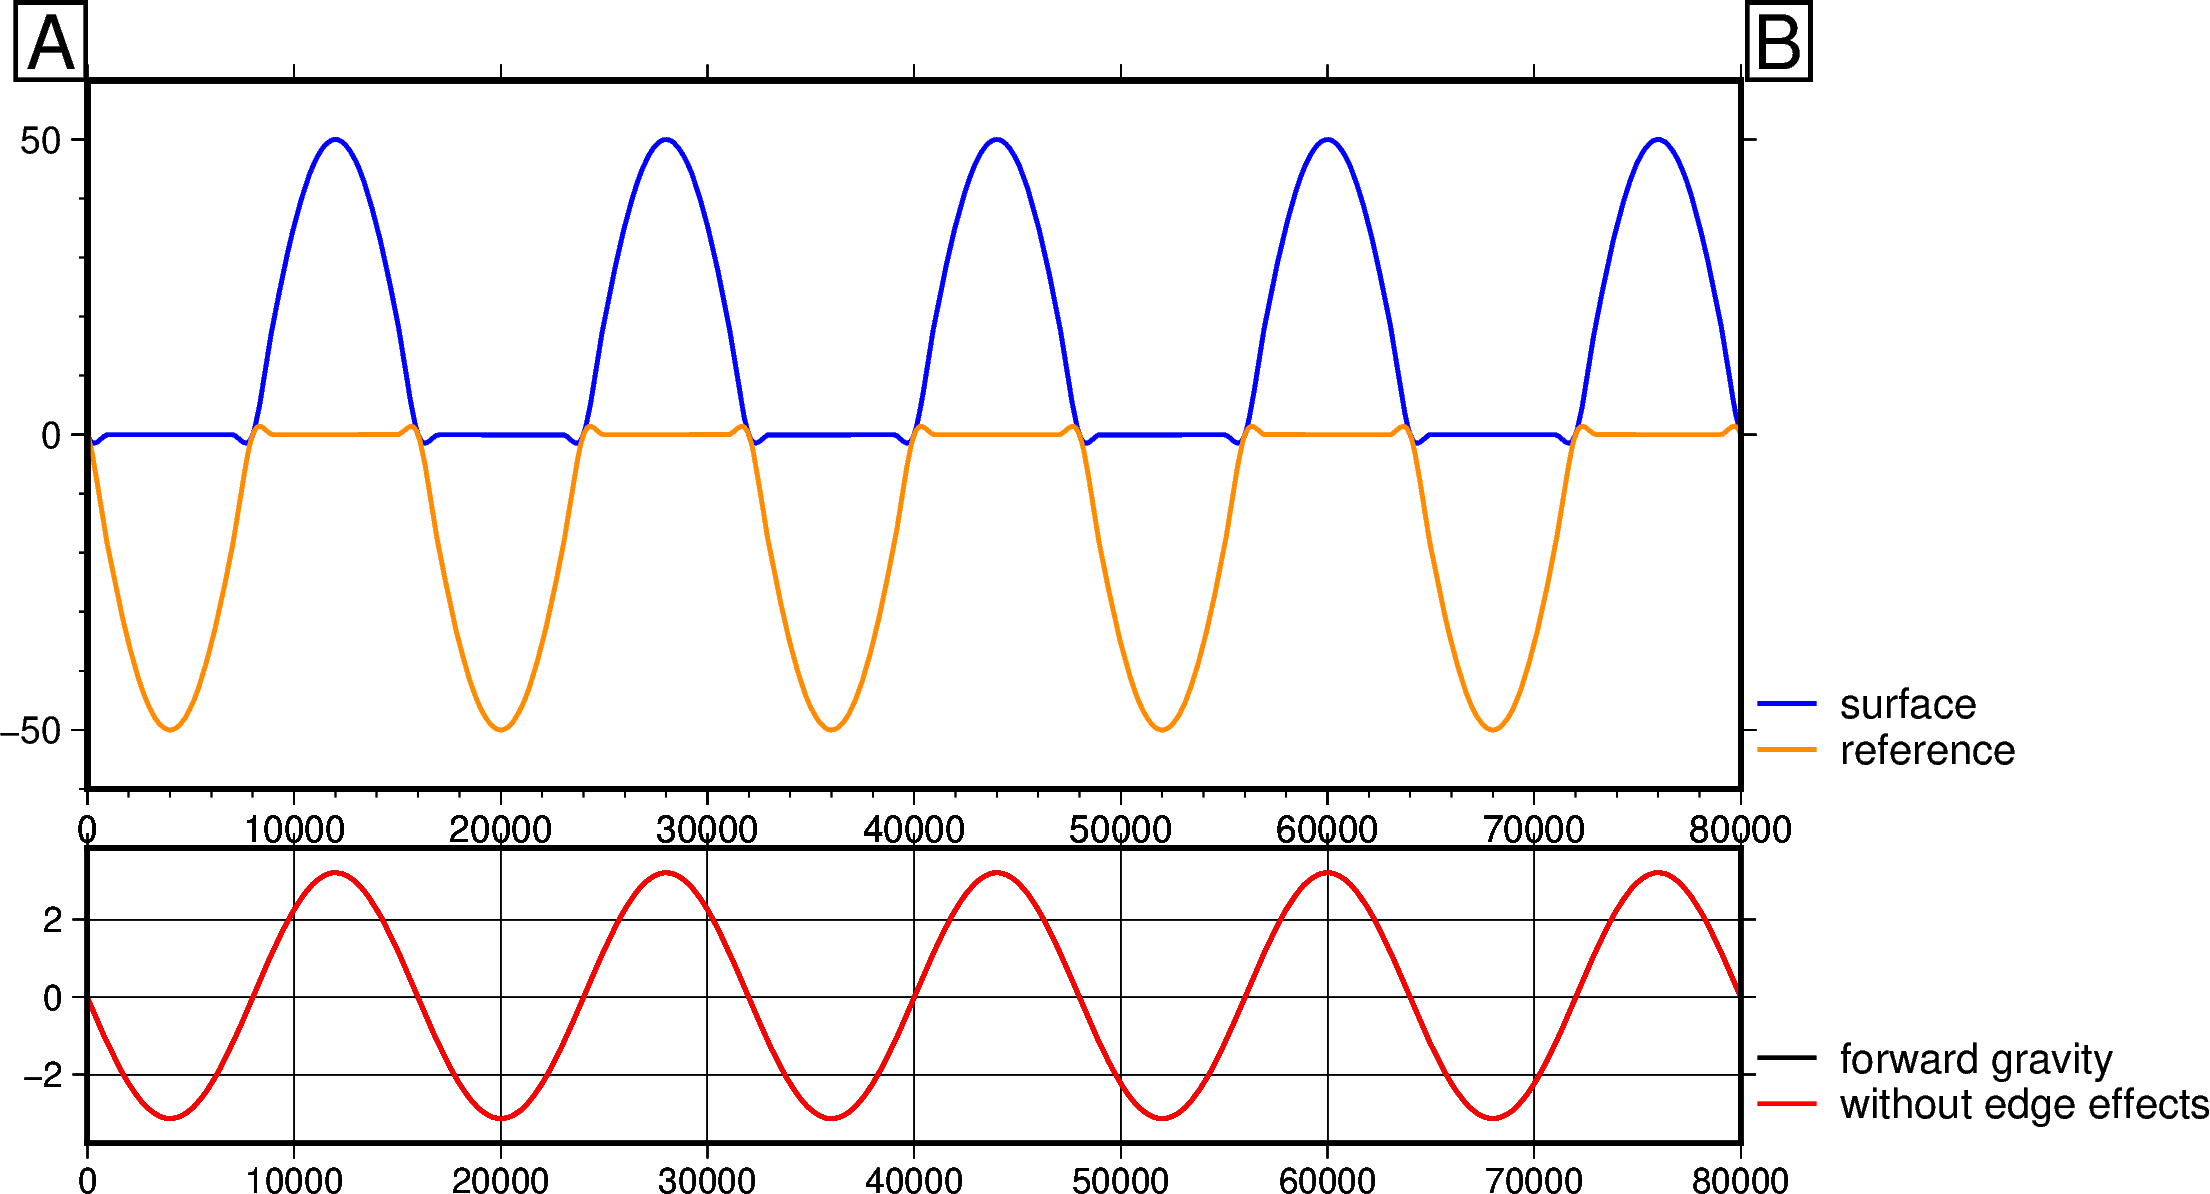

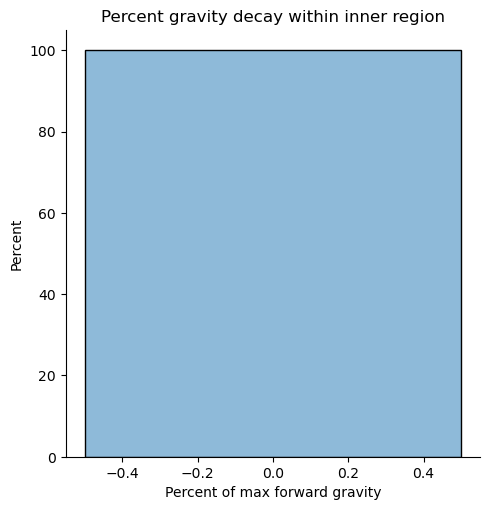

makecpt [ERROR]: Option T: min >= max


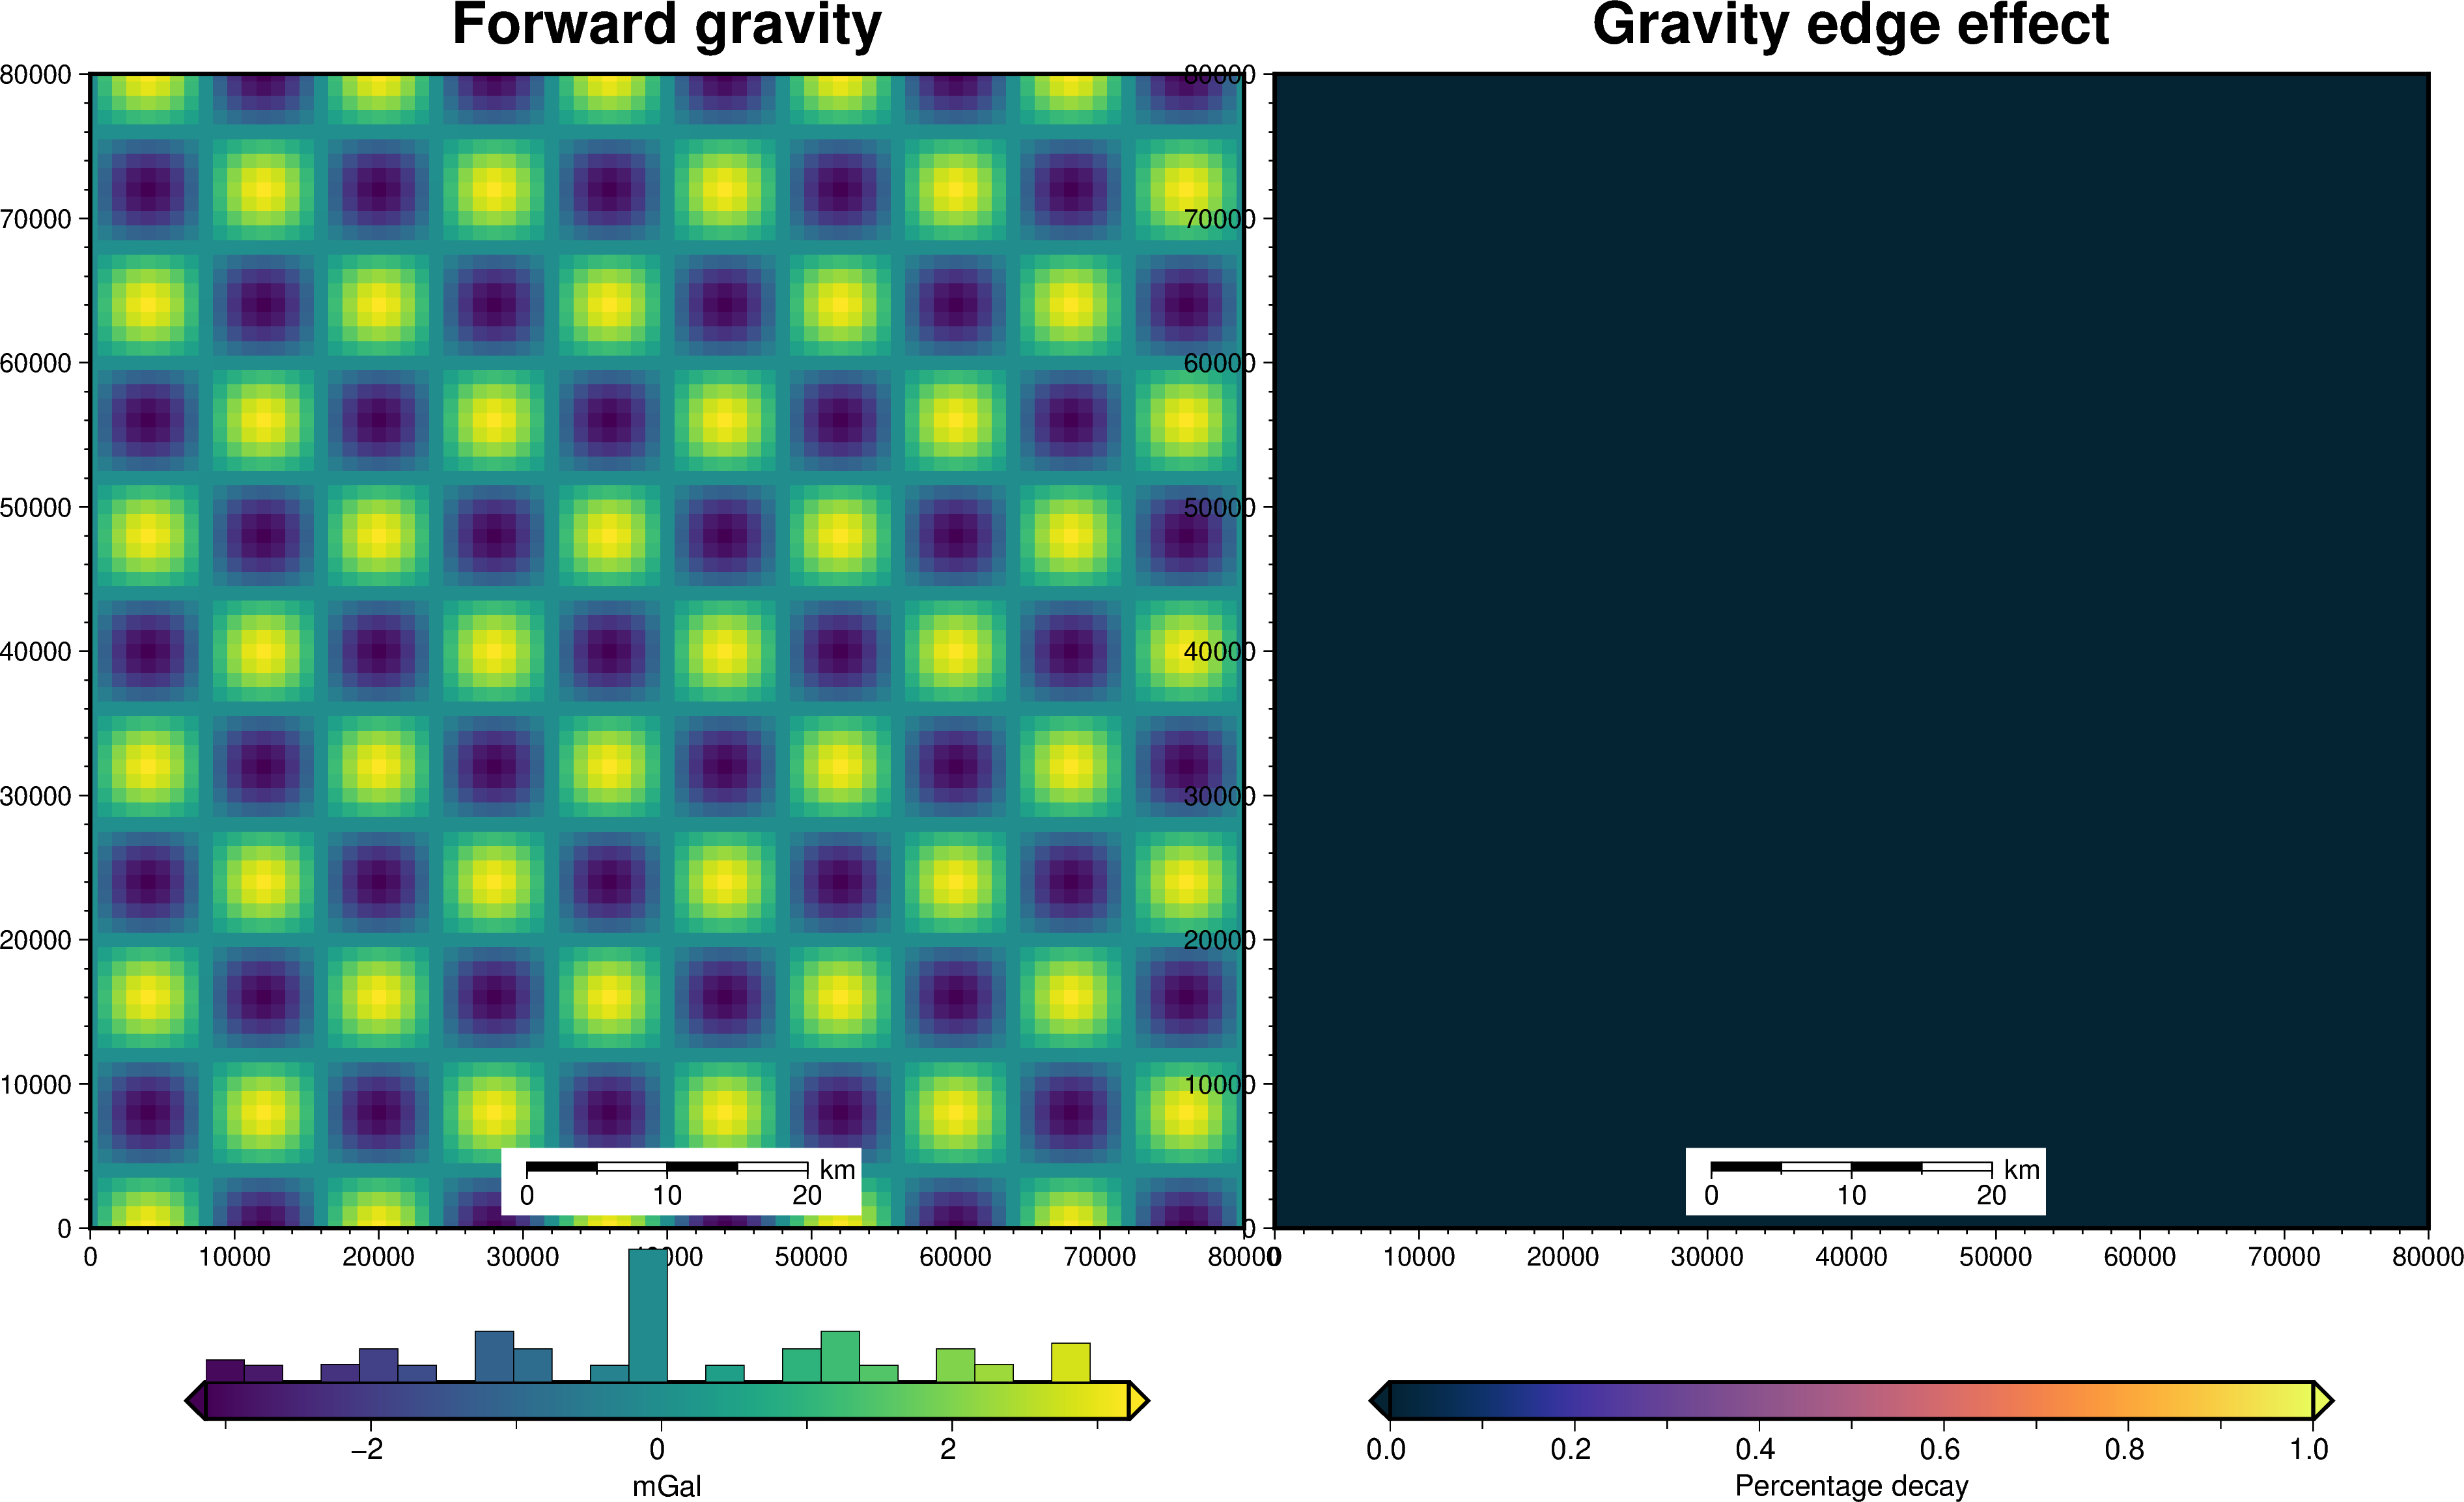

maximum decay: 0% 
buffer: 8000.0m / 8 cells


In [11]:
results = inv_utils.gravity_decay_buffer(
    buffer_perc=10,
    obs_height=1e3,
    top=0,
    zref=-4e3,
    spacing=1e3,
    inner_region=[0e3, 80e3, 0e3, 80e3],
    density=2670,
    as_density_contrast=True,
    checkerboard=True,
    amplitude=50,
    wavelength=16e3,
    plot=True,
    plot_profile=True,
)
print(
    f"maximum decay: {int(results[0])}% \n"
    f"buffer: {results[1]}m / {int(results[2])} cells"
)

Note how the there is no edge effect. This is due to both the lower average prism density and the smaller average prism heights.

# Example 4
Here we use real bed data to see the gravity edge effect with a standard absolute density discretization approach.

grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


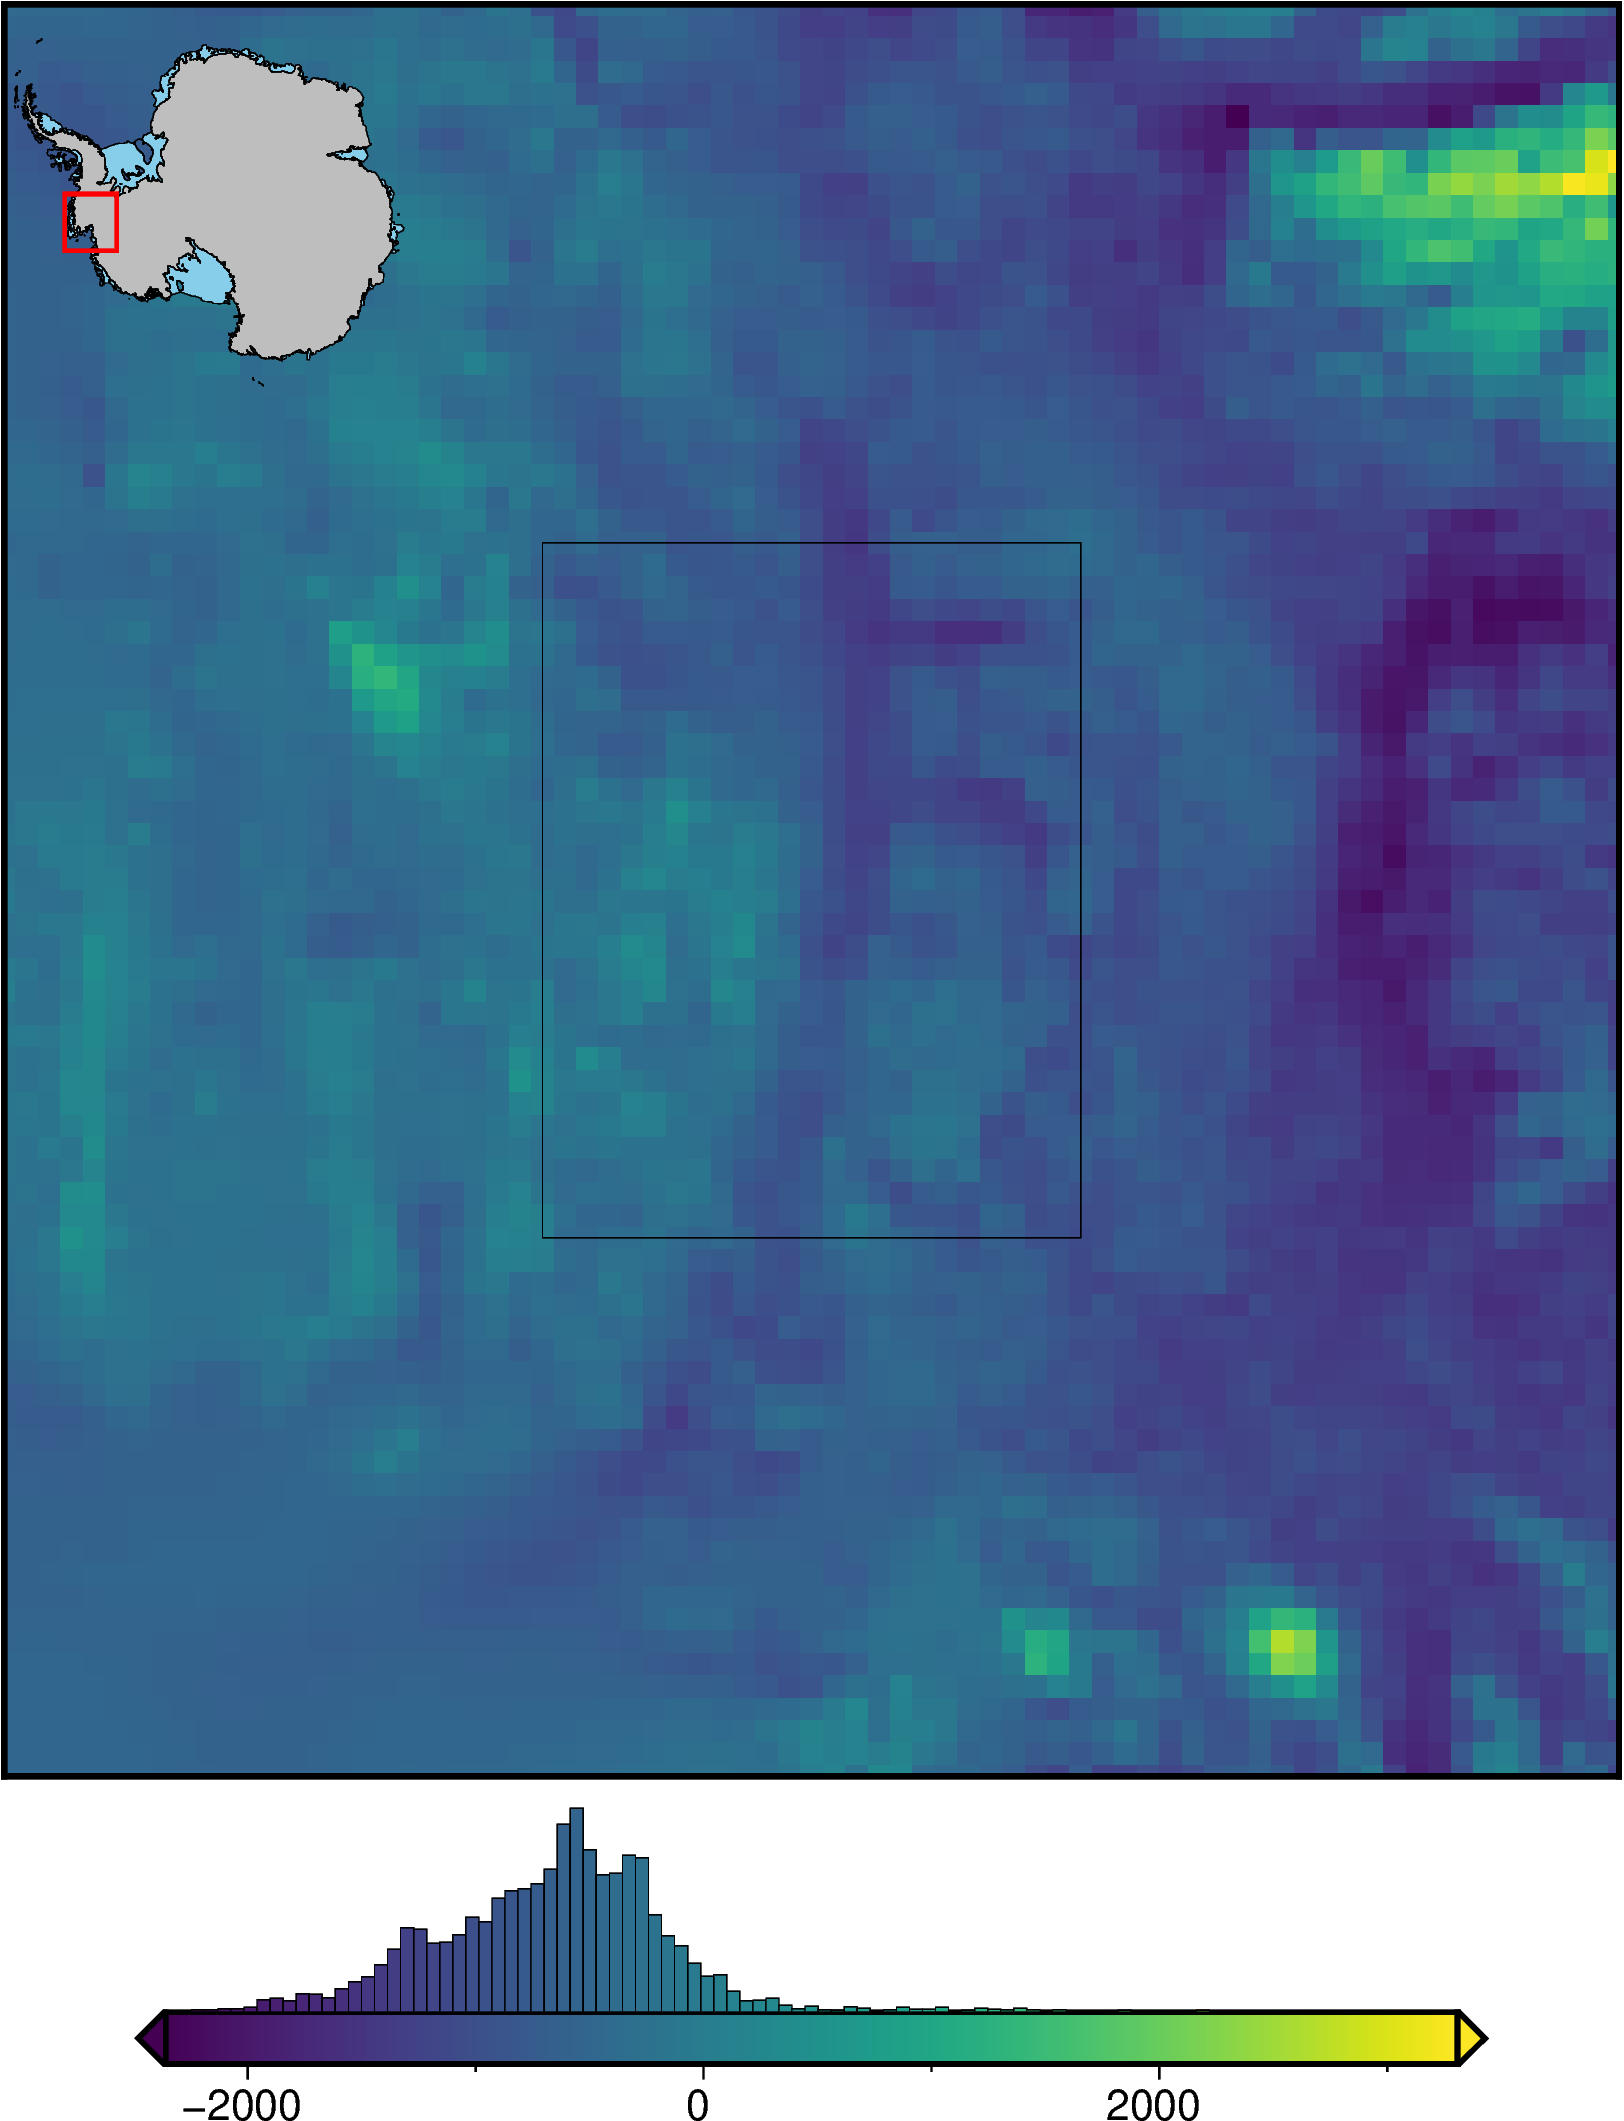

inner region: (-1720000.0, -1480000.0, -380000.0, -70000.0)
buffer region: (-1960000.0, -1240000.0, -620000.0, 170000.0)


In [12]:
# set regions
inner_region = regions.pine_island_glacier
buffer_region = regions.alter_region(
    inner_region,
    zoom=-(inner_region[1] - inner_region[0]),
)

# fetch data
bed_buffer = fetch.bedmap2(layer="bed", spacing=10e3, region=buffer_region)
bed_inner = fetch.bedmap2(layer="bed", spacing=10e3, region=inner_region)

# plot map
fig = maps.plot_grd(
    bed_buffer,
    region=buffer_region,
    show_region=inner_region,
    hist=True,
    inset=True,
)
fig.show()

print(f"inner region: {inner_region}")
print(f"buffer region: {buffer_region}")

In [13]:
# create ice prisms above bed
ice_prisms_buffer = inv_utils.grids_to_prisms(
    surface=bed_buffer,
    reference=bed_buffer.values.max(),
    density=917,
    input_coord_names=["x", "y"],
)

# create rock prisms below bed
rock_prisms_buffer = inv_utils.grids_to_prisms(
    surface=bed_buffer,
    reference=bed_buffer.values.min(),
    density=2300,
    input_coord_names=["x", "y"],
)

# repeat but only with inner region
# create ice prisms above bed
ice_prisms_inner = inv_utils.grids_to_prisms(
    surface=bed_inner,
    reference=bed_inner.values.max(),
    density=917,
    input_coord_names=["x", "y"],
)

# create rock prisms below bed
rock_prisms_inner = inv_utils.grids_to_prisms(
    surface=bed_inner,
    reference=bed_inner.values.min(),
    density=2300,
    input_coord_names=["x", "y"],
)

In [14]:
# set observation points
coords = vd.grid_coordinates(
    region=inner_region,
    spacing=2e3,
    pixel_register=False,
)

# turn coordinates into dataarray
grav = vd.make_xarray_grid(
    coords, data=np.ones_like(coords[0]) * 1e3, data_names="z", dims=("y", "x")
)
# turn dataarray into dataframe
grav_df = vd.grid_to_table(grav)

num_grav = len(grav_df)

grav_df

y          x       z
0     -380000.0 -1720000.0  1000.0
1     -380000.0 -1718000.0  1000.0
2     -380000.0 -1716000.0  1000.0
3     -380000.0 -1714000.0  1000.0
4     -380000.0 -1712000.0  1000.0
...         ...        ...     ...
18871  -70000.0 -1488000.0  1000.0
18872  -70000.0 -1486000.0  1000.0
18873  -70000.0 -1484000.0  1000.0
18874  -70000.0 -1482000.0  1000.0
18875  -70000.0 -1480000.0  1000.0

[18876 rows x 3 columns]

In [15]:
# calculate gravity of full region prisms
time_start = time.perf_counter()
grav_df["ice_prisms_buffer"] = ice_prisms_buffer.prism_layer.gravity(
    coordinates=(
        grav_df.x,
        grav_df.y,
        grav_df.z,
    ),
    field="g_z",
    progressbar=True,
)
grav_df["rock_prisms_buffer"] = rock_prisms_buffer.prism_layer.gravity(
    coordinates=(
        grav_df.x,
        grav_df.y,
        grav_df.z,
    ),
    field="g_z",
    progressbar=True,
)
buffer_abs_time = int(time.perf_counter() - time_start)


# calculate gravity of inner region prisms
time_start = time.perf_counter()
grav_df["ice_prisms_inner"] = ice_prisms_inner.prism_layer.gravity(
    coordinates=(
        grav_df.x,
        grav_df.y,
        grav_df.z,
    ),
    field="g_z",
    progressbar=True,
)
grav_df["rock_prisms_inner"] = rock_prisms_inner.prism_layer.gravity(
    coordinates=(
        grav_df.x,
        grav_df.y,
        grav_df.z,
    ),
    field="g_z",
    progressbar=True,
)
inner_abs_time = int(time.perf_counter() - time_start)

print(f"Buffer zone execution time: {buffer_abs_time} seconds")
print(f"Inner zone execution time: {inner_abs_time} seconds")

num_buffer_ice_prisms = len(ice_prisms_buffer.northing) * len(ice_prisms_buffer.easting)
num_buffer_rock_prisms = len(rock_prisms_buffer.northing) * len(
    rock_prisms_buffer.easting
)
num_buffer_abs_prisms = num_buffer_ice_prisms + num_buffer_rock_prisms

num_inner_ice_prisms = len(ice_prisms_inner.northing) * len(ice_prisms_inner.easting)
num_inner_rock_prisms = len(rock_prisms_inner.northing) * len(rock_prisms_inner.easting)
num_inner_abs_prisms = num_inner_ice_prisms + num_inner_rock_prisms

print(f"{num_grav} gravity points")
print(f"{num_buffer_abs_prisms} prisms with buffer zone")
print(f"{num_inner_abs_prisms} prisms without buffer zone")
print(f"{num_grav*num_buffer_abs_prisms} forward gravity calculations with buffer zone")
print(
    f"{num_grav*num_inner_abs_prisms} forward gravity calculations without buffer zone"
)

  0%|          | 0/18876 [00:00<?, ?it/s]

  0%|          | 0/18876 [00:00<?, ?it/s]

  0%|          | 0/18876 [00:00<?, ?it/s]

  0%|          | 0/18876 [00:00<?, ?it/s]

Buffer zone execution time: 7 seconds
Inner zone execution time: 1 seconds
18876 gravity points
11680 prisms with buffer zone
1600 prisms without buffer zone
220471680 forward gravity calculations with buffer zone
30201600 forward gravity calculations without buffer zone


In [16]:
grav_df["buffer_abs_grav_total"] = (
    grav_df.ice_prisms_buffer + grav_df.rock_prisms_buffer
)
grav_df["inner_abs_grav_total"] = grav_df.ice_prisms_inner + grav_df.rock_prisms_inner

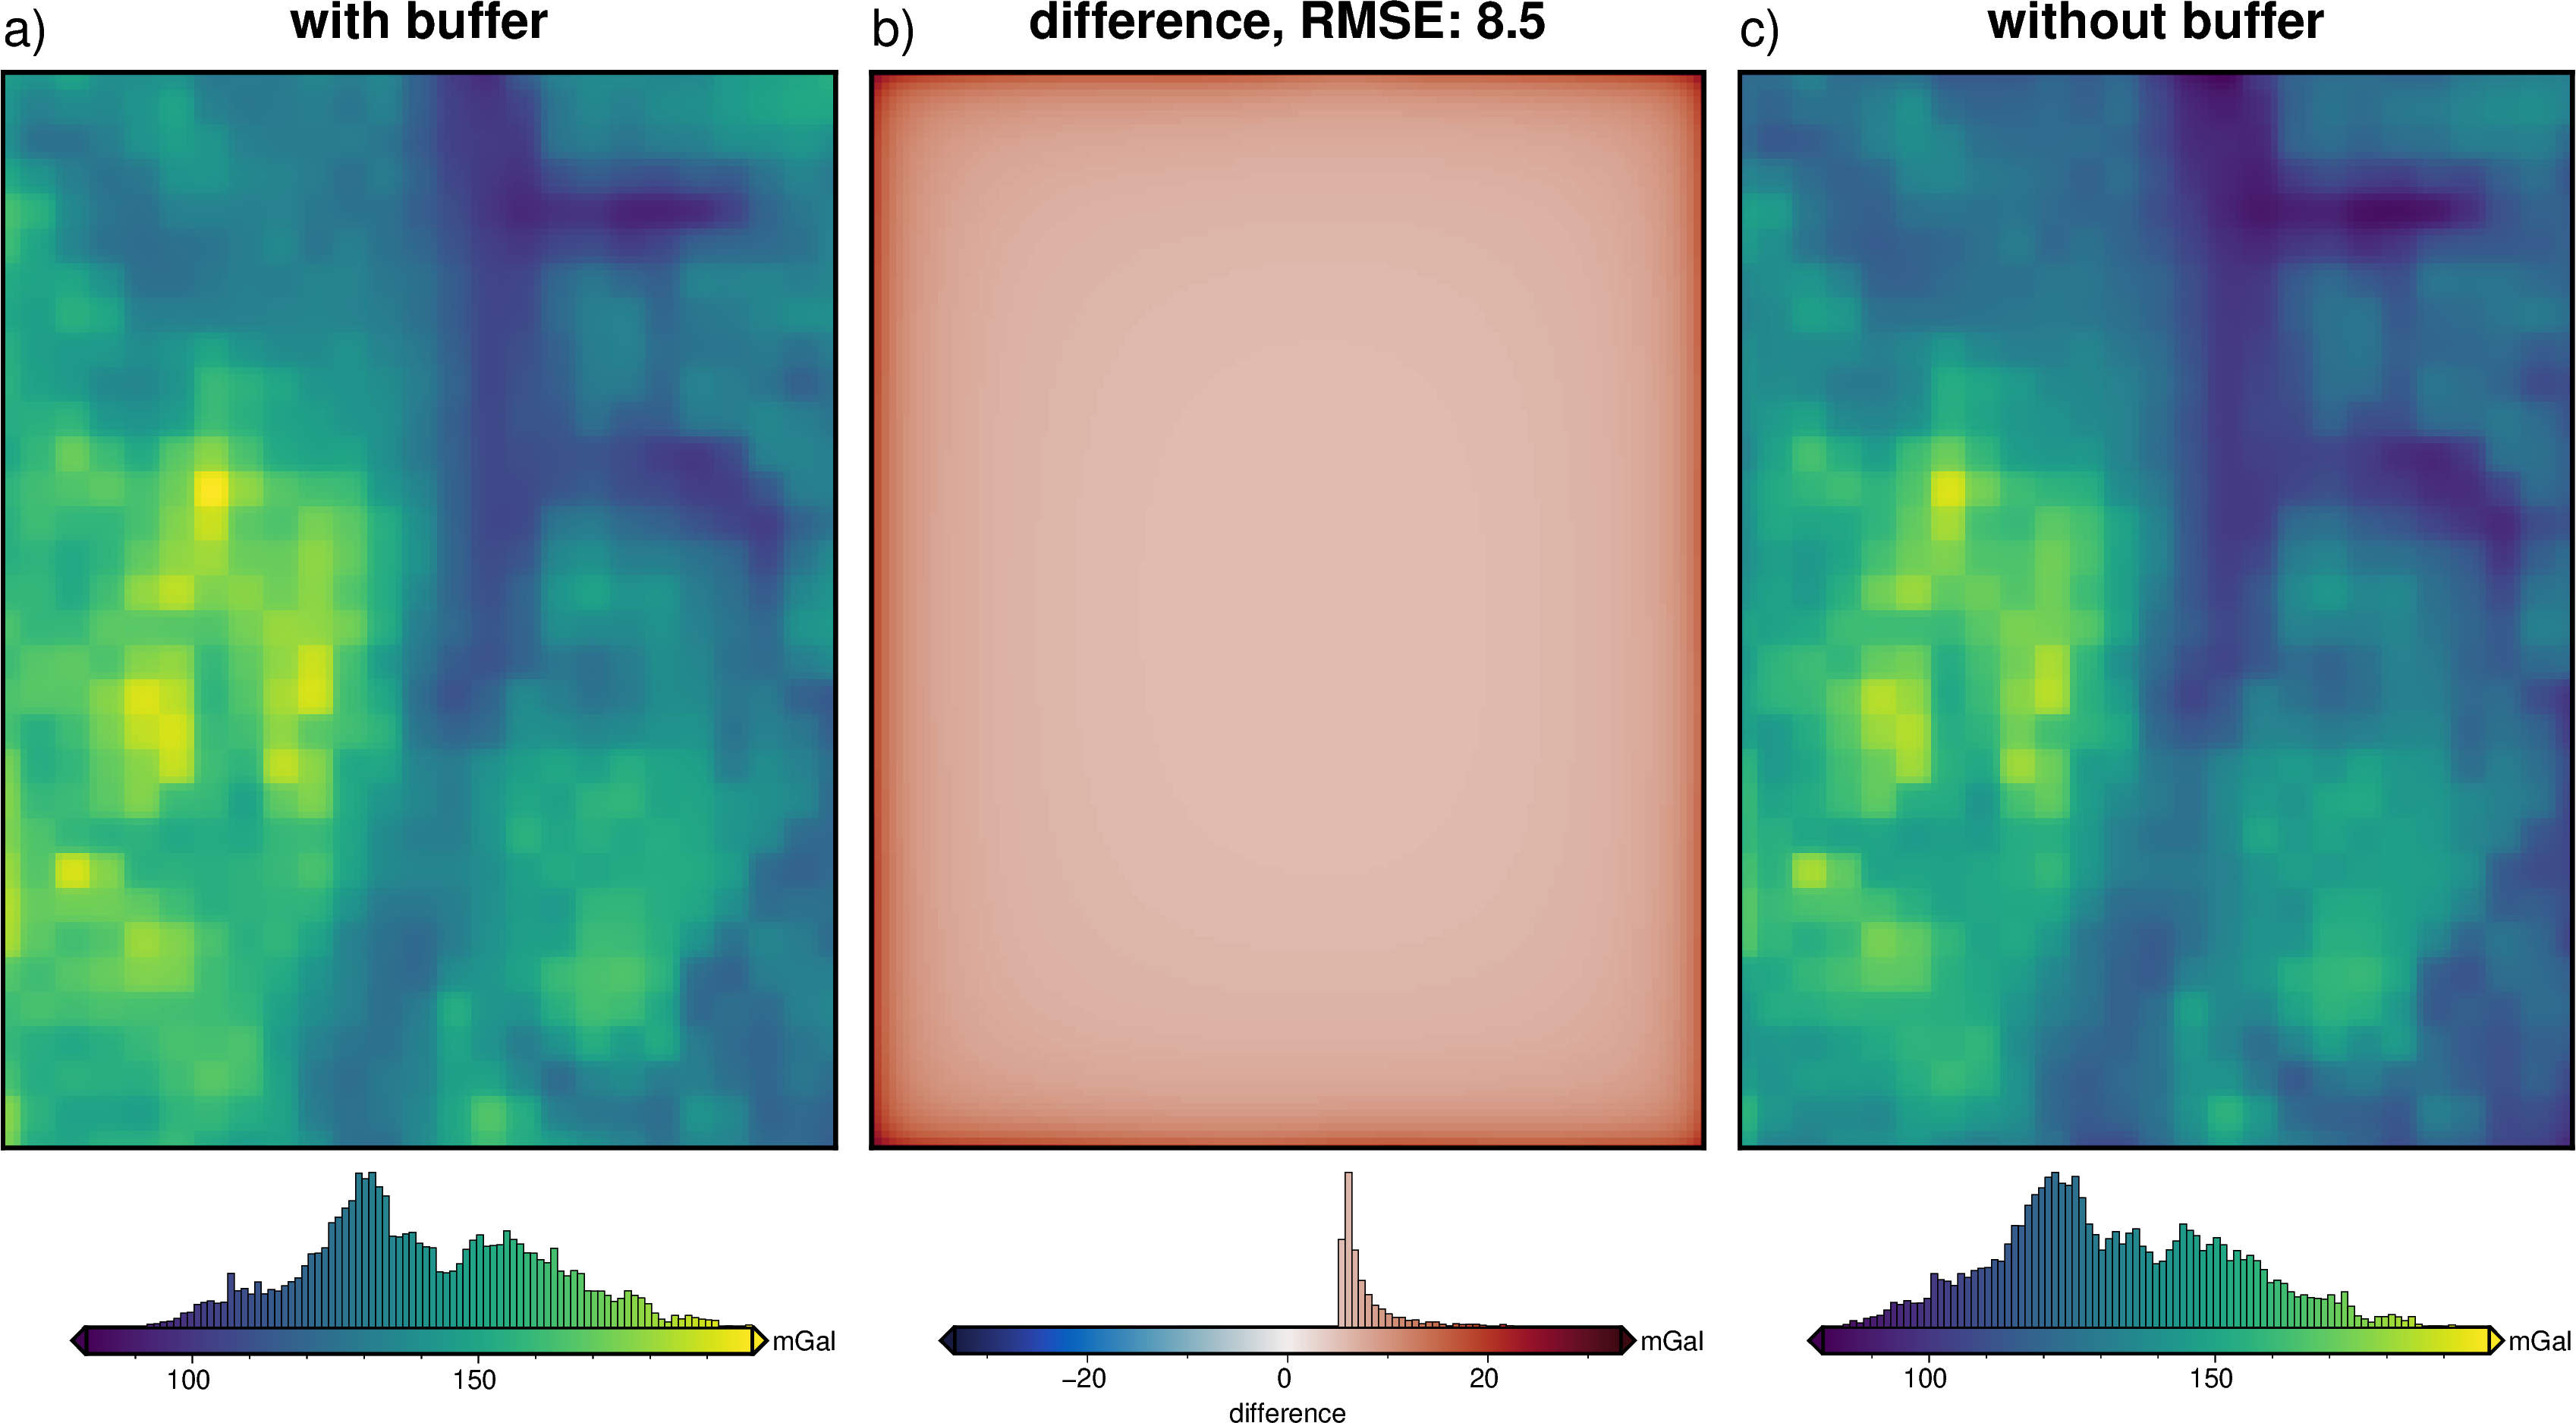

In [17]:
# grid the grav data
grav_grids = grav_df.set_index(["y", "x"]).to_xarray()

absolute_grids = utils.grd_compare(
    grav_grids.buffer_abs_grav_total,
    grav_grids.inner_abs_grav_total,
    plot=True,
    verbose="e",
    grid1_name="with buffer",
    grid2_name="without buffer",
    title="difference",
    hist=True,
    inset=False,
    coast=False,
    cbar_unit="mGal",
    subplot_labels=True,
    RMSE_decimates=1,
    diff_cmap="balance+h0",
    label_font="16p",
    title_font="16p",
)

# Example 5
Here we repeat Example 4, but using the reference surface discretization method. This shows that this method of discretizing a surface into prisms doesn't require a buffer region, and therefore saves a significant amount of computation.

In [18]:
# create prisms around mean bed elevation
# positive densities above reference, negative below
zref_prisms_buffer = inv_utils.grids_to_prisms(
    surface=bed_buffer,
    reference=bed_buffer.values.mean(),
    density=xr.where(
        bed_buffer >= bed_buffer.values.mean(), (2300 - 917), -(2300 - 917)
    ),
    input_coord_names=["x", "y"],
)

# repeat but only with inner region
zref_prisms_inner = inv_utils.grids_to_prisms(
    surface=bed_inner,
    reference=bed_inner.values.mean(),
    density=xr.where(bed_inner >= bed_inner.values.mean(), (2300 - 917), -(2300 - 917)),
    input_coord_names=["x", "y"],
)

In [19]:
# calculate gravity of full region prisms
time_start = time.perf_counter()
grav_df["zref_prisms_buffer"] = zref_prisms_buffer.prism_layer.gravity(
    coordinates=(
        grav_df.x,
        grav_df.y,
        grav_df.z,
    ),
    field="g_z",
    progressbar=True,
)
buffer_zref_time = int(time.perf_counter() - time_start)

# calculate gravity of inner region prisms
time_start = time.perf_counter()
grav_df["zref_prisms_inner"] = zref_prisms_inner.prism_layer.gravity(
    coordinates=(
        grav_df.x,
        grav_df.y,
        grav_df.z,
    ),
    field="g_z",
    progressbar=True,
)
inner_zref_time = int(time.perf_counter() - time_start)

print(f"Buffer zone execution time: {buffer_zref_time} seconds")
print(f"Inner zone execution time: {inner_zref_time} seconds")

num_buffer_zref_prisms = len(zref_prisms_buffer.northing) * len(
    zref_prisms_buffer.easting
)
num_inner_zref_prisms = len(zref_prisms_inner.northing) * len(zref_prisms_inner.easting)

print(f"{num_grav} gravity points")
print(f"{num_buffer_zref_prisms} prisms with buffer zone")
print(f"{num_inner_zref_prisms} prisms without buffer zone")
print(
    f"{num_grav*num_buffer_zref_prisms} forward gravity calculations with buffer zone"
)
print(
    f"{num_grav*num_inner_zref_prisms} forward gravity calculations without buffer zone"
)

  0%|          | 0/18876 [00:00<?, ?it/s]

  0%|          | 0/18876 [00:00<?, ?it/s]

Buffer zone execution time: 3 seconds
Inner zone execution time: 0 seconds
18876 gravity points
5840 prisms with buffer zone
800 prisms without buffer zone
110235840 forward gravity calculations with buffer zone
15100800 forward gravity calculations without buffer zone


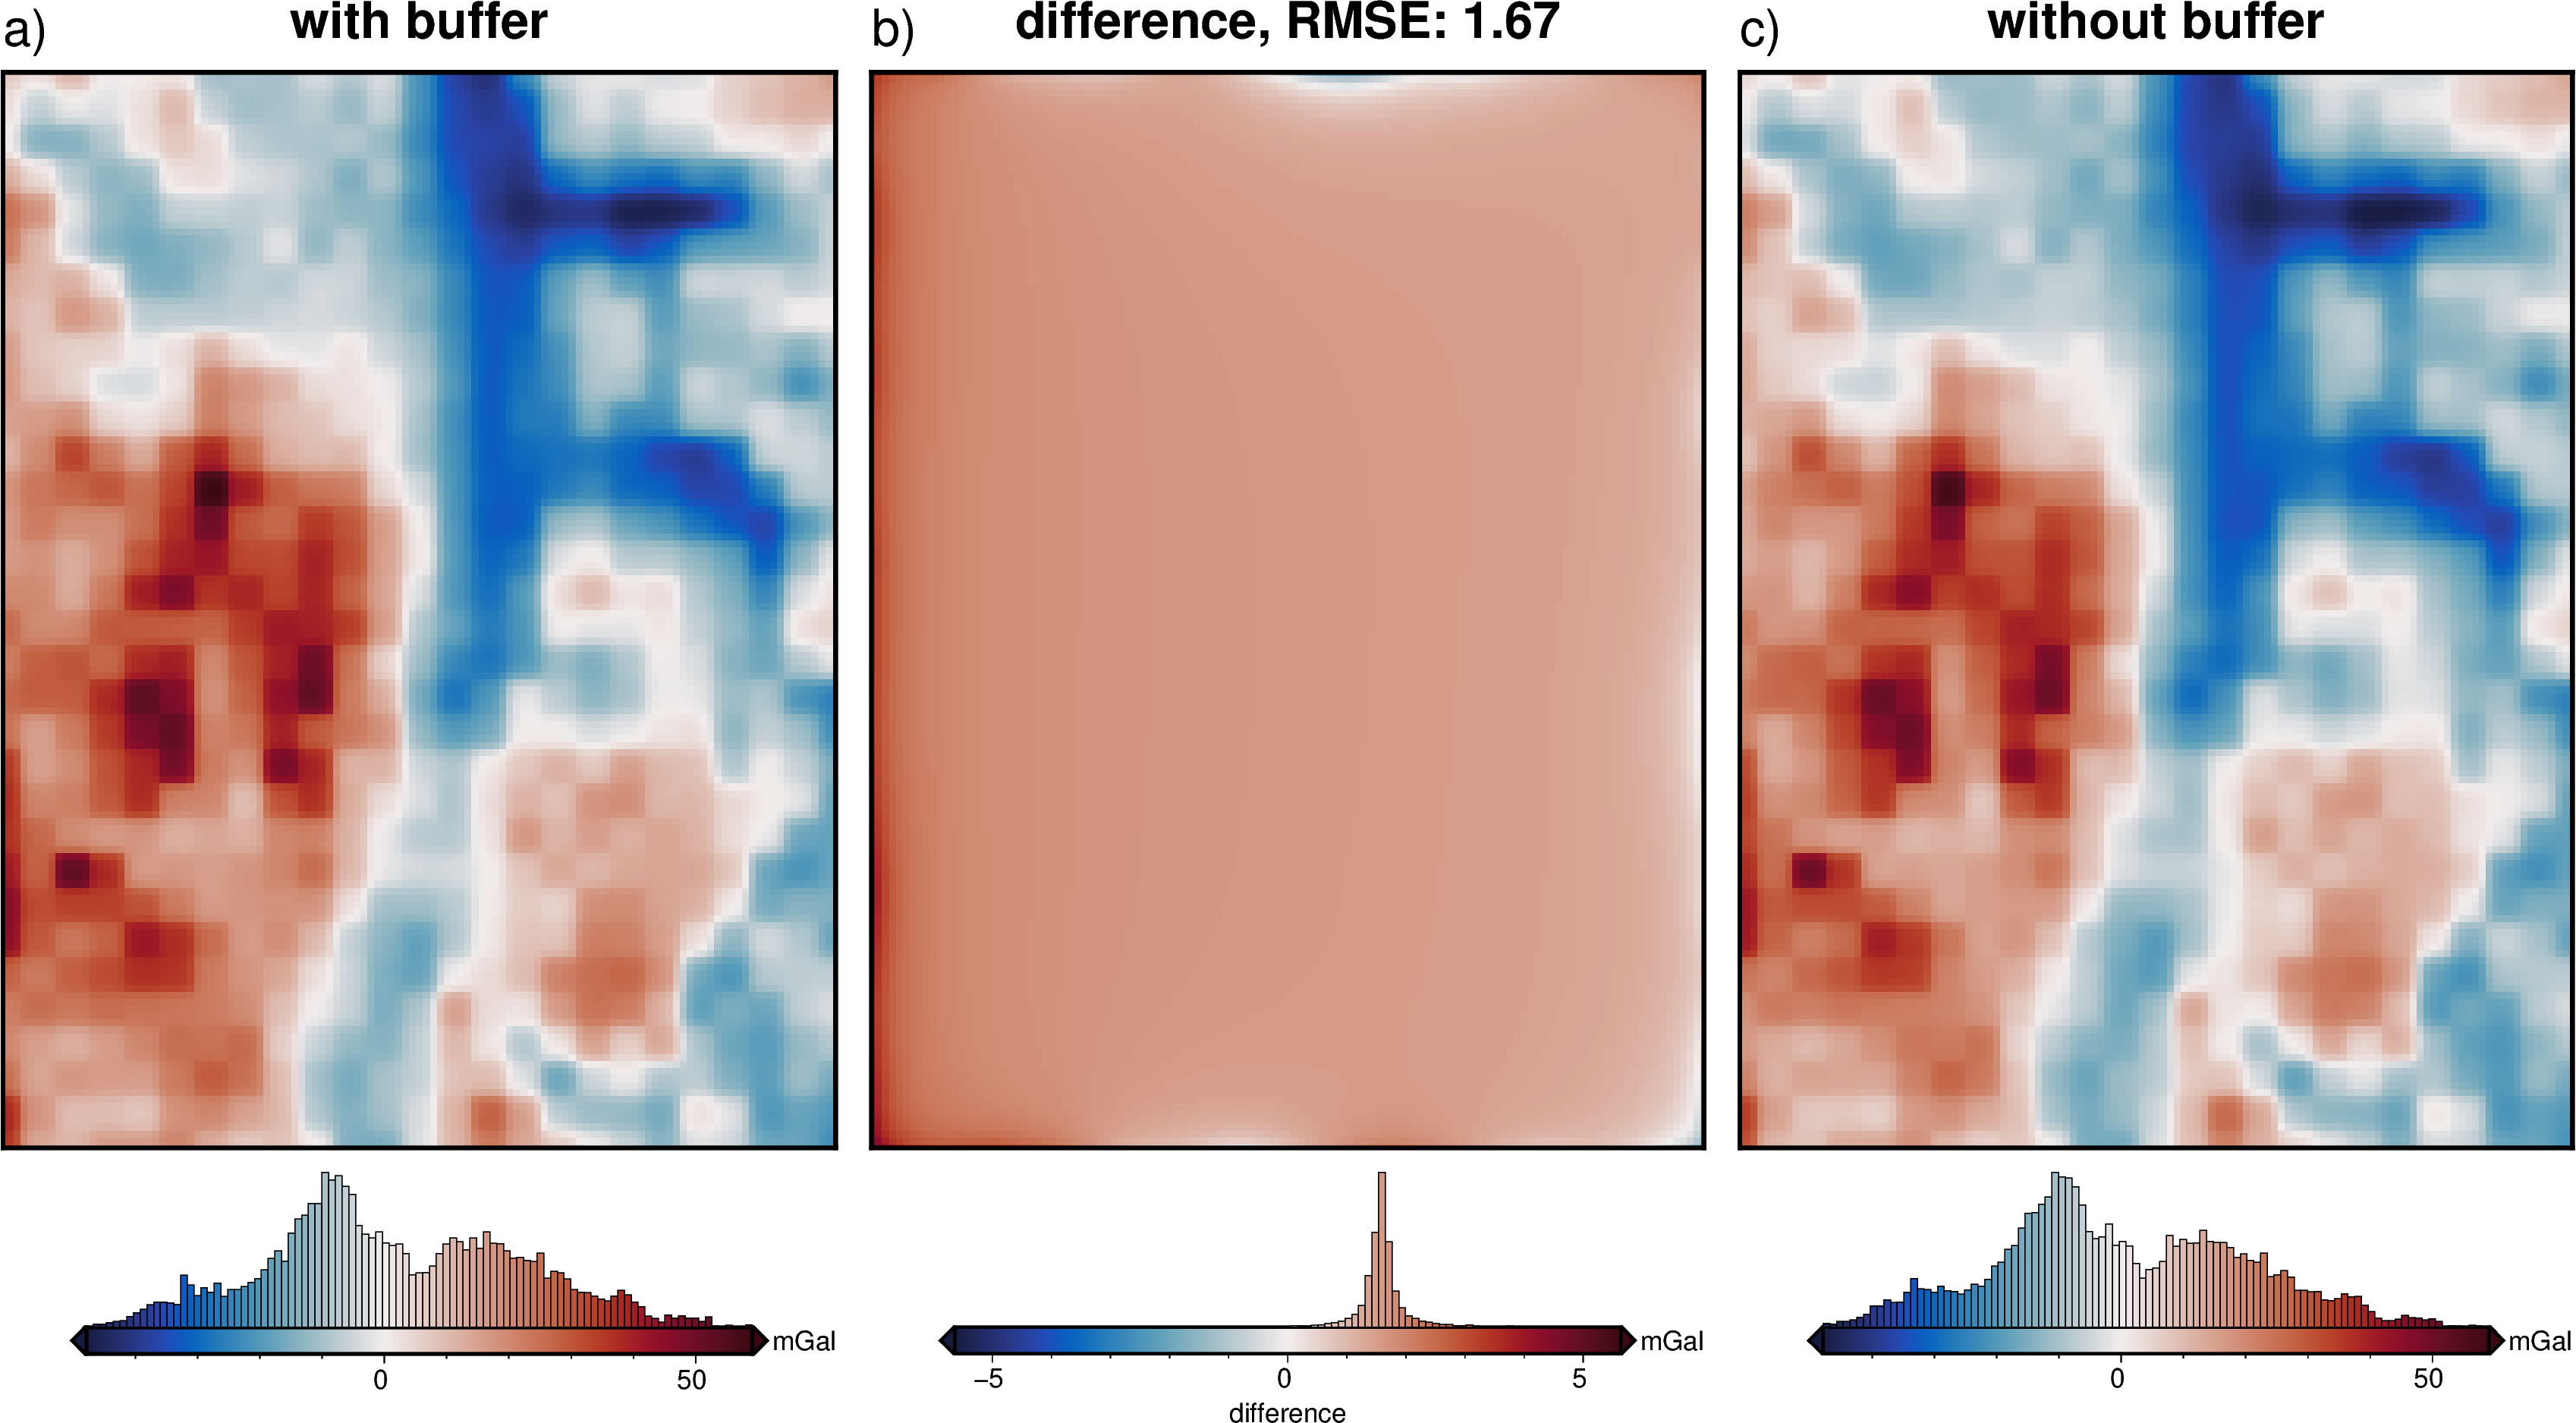

In [20]:
# grid the grav data
grav_grids = grav_df.set_index(["y", "x"]).to_xarray()

zref_grids = utils.grd_compare(
    grav_grids.zref_prisms_buffer,
    grav_grids.zref_prisms_inner,
    plot=True,
    cmap="balance+h0",
    verbose="e",
    grid1_name="with buffer",
    grid2_name="without buffer",
    title="difference",
    hist=True,
    inset=False,
    coast=False,
    cbar_unit="mGal",
    subplot_labels=True,
    RMSE_decimates=1,
    diff_cmap="balance+h0",
    label_font="16p",
    title_font="16p",
)

### Compare edge effects
Here we compare the magnitude of gravity edge effects with the two discretization methods of Ex 4 and 5.

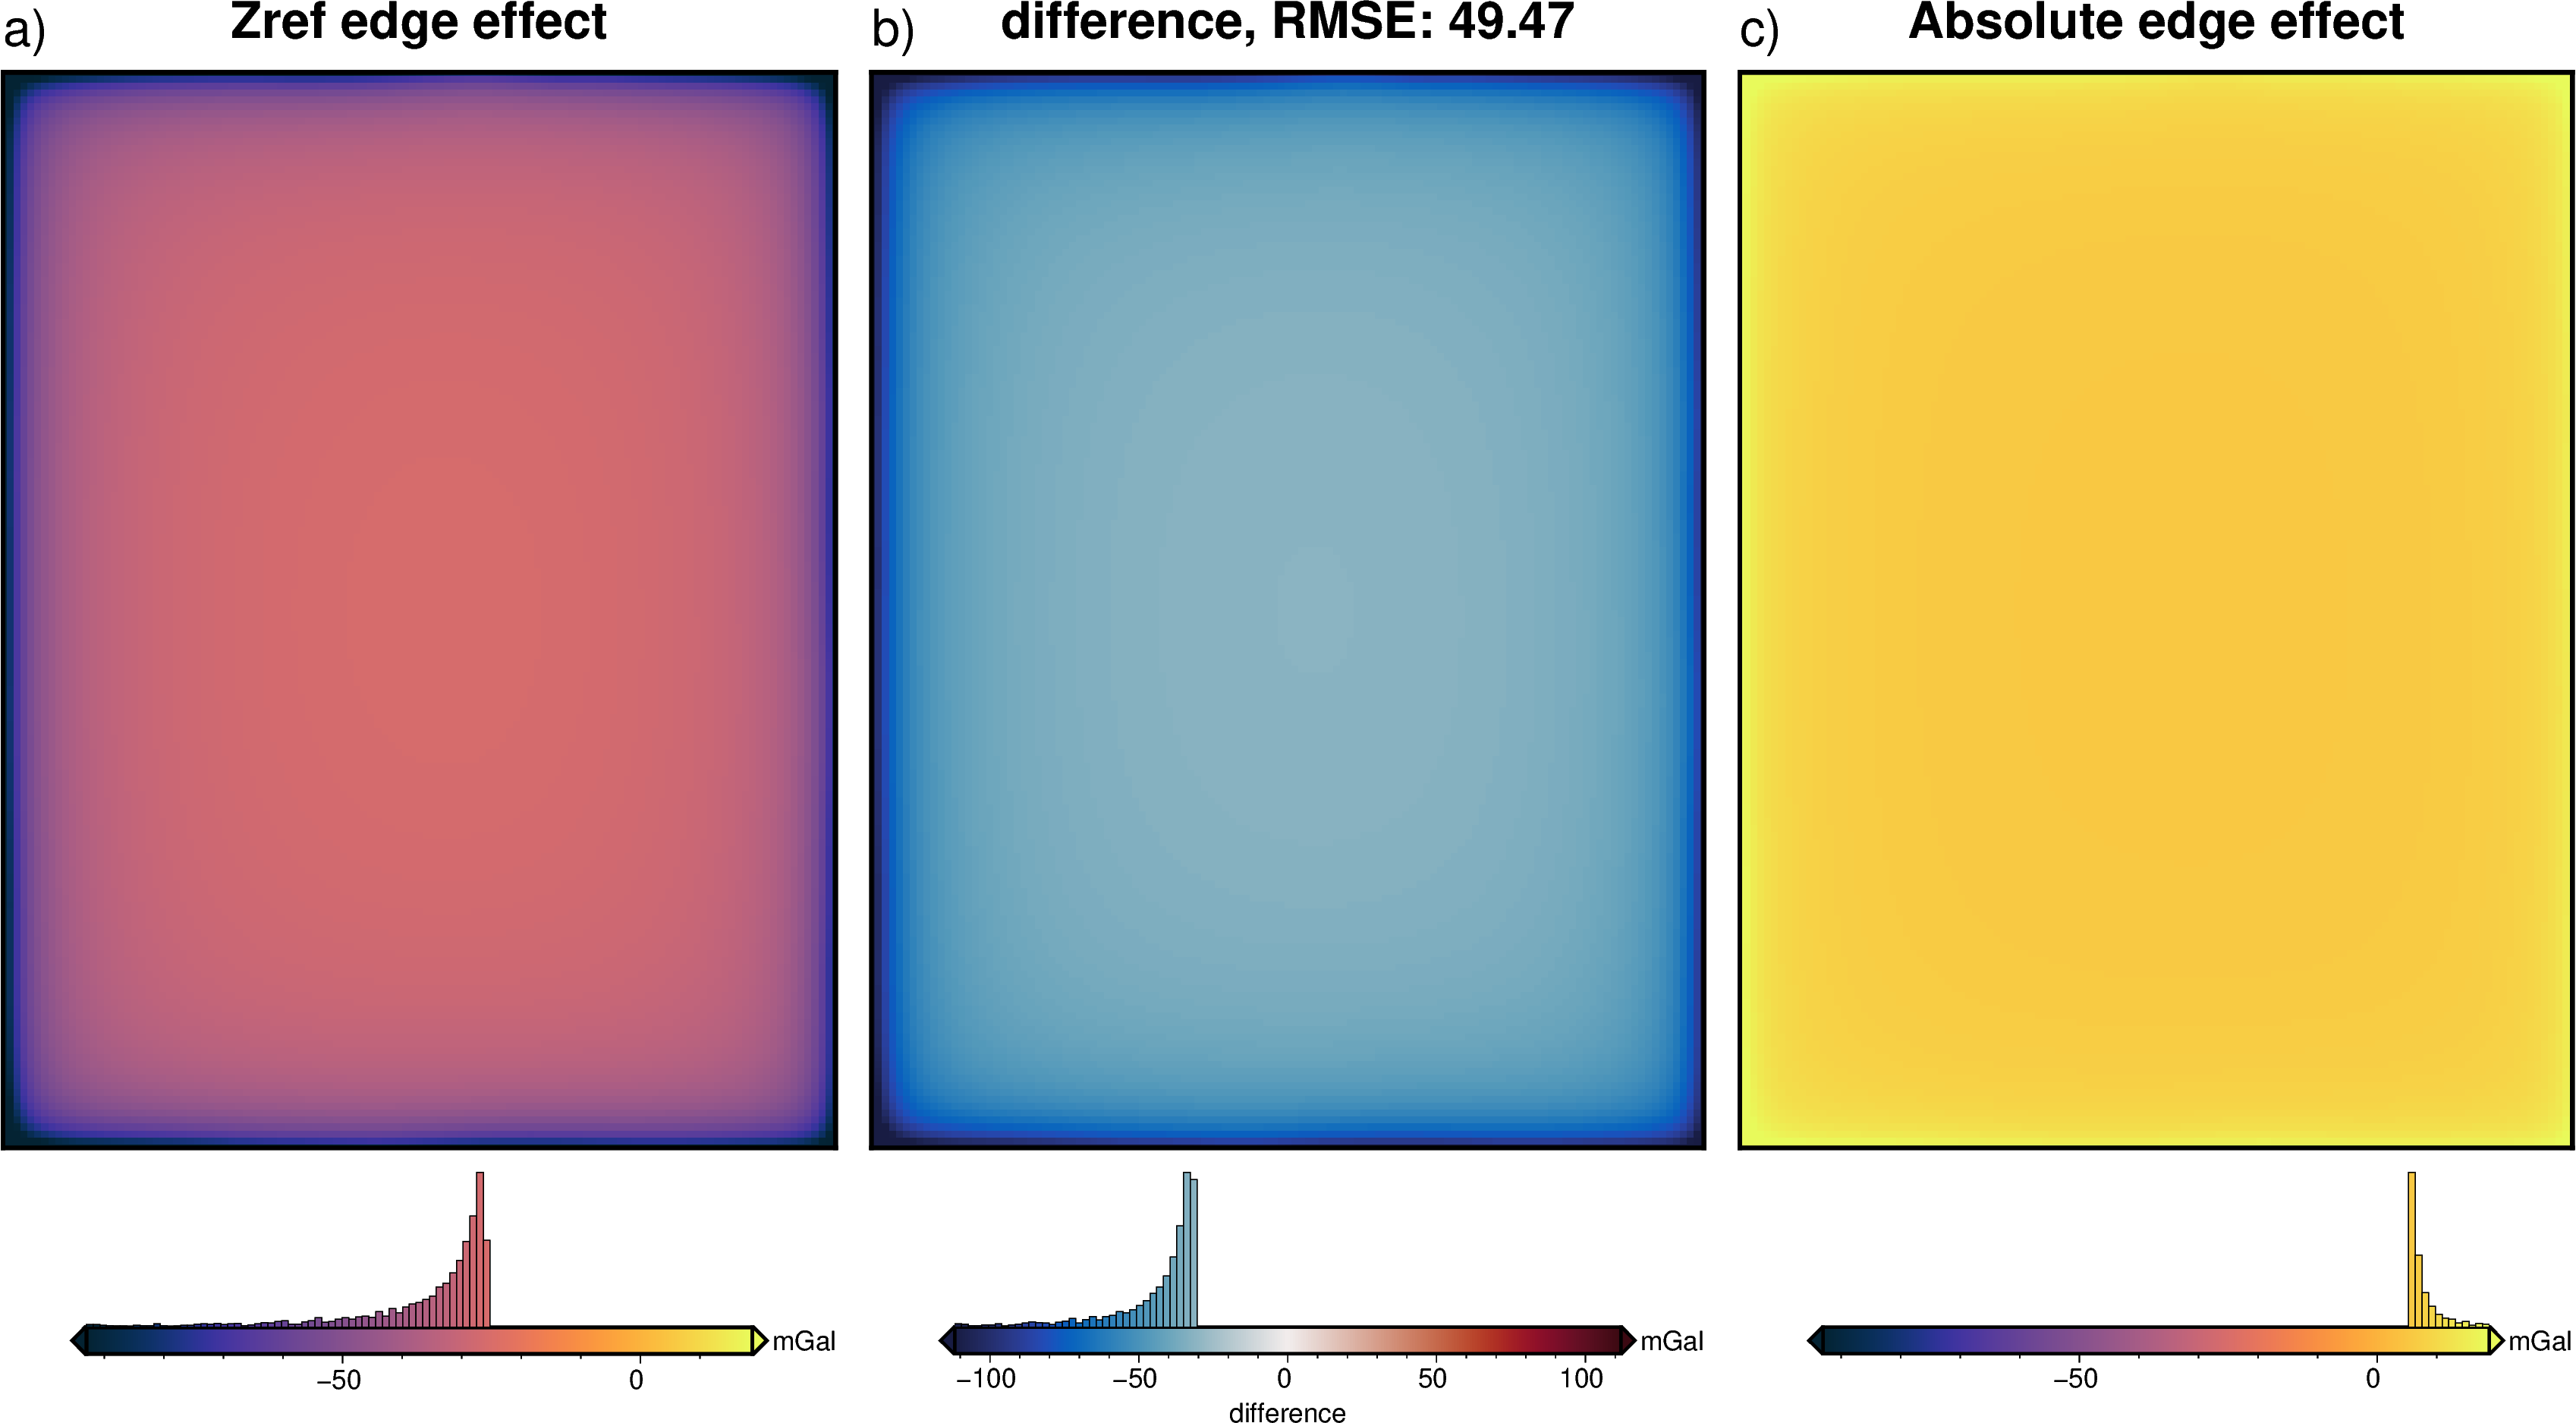

30201600 forward gravity calculations with absolute density method
15100800 forward gravity calculations with zref method
Absolute density execution time: 0 seconds
Zref execution time: 0 seconds


In [26]:
zref_edge_effect = zref_grids[0]
absolute_edge_effect = absolute_grids[0]

zref_grids = utils.grd_compare(
    zref_edge_effect,
    absolute_edge_effect,
    plot=True,
    cmap="thermal",
    verbose="e",
    grid1_name="Zref edge effect",
    grid2_name="Absolute edge effect",
    title="difference",
    hist=True,
    inset=False,
    coast=False,
    cbar_unit="mGal",
    subplot_labels=True,
    diff_cmap="balance+h0",
    label_font="16p",
    title_font="16p",
    robust=True,
)

print(
    f"{num_grav*num_inner_abs_prisms} forward gravity calculations with absolute density method"
)
print(f"{num_grav*num_inner_zref_prisms} forward gravity calculations with zref method")
print(f"Absolute density execution time: {inner_zref_time} seconds")
print(f"Zref execution time: {inner_zref_time} seconds")